<a href="https://colab.research.google.com/github/dmalya96/GAN/blob/main/Vanilla_GAN_Cifar10_IGMD_Layers_Frog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Vanilla GAN on Cifar 10 (Frog Images)

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from matplotlib import pyplot

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
  model = tf.keras.Sequential()
  # foundation for 4x4 image
  model.add(layers.Dense(4*4*512, use_bias=False, input_dim=latent_dim))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Reshape((4, 4, 512)))
  # upsample to 8x8
  model.add(layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # upsample to 16x16
  model.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # upsample to 32x32
  model.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # output layer
  model.add(layers.Conv2D(3, (5,5), activation='tanh', padding='same'))
  return model

In [ ]:
# define the standalone discriminator model
def define_discriminator():
  model = tf.keras.Sequential()
  # normal
  model.add(layers.Conv2D(96, (3,3), padding='same', input_shape=[32, 32, 3]))
  model.add(layers.LeakyReLU(alpha=0.2))
  # downsample
  model.add(layers.Conv2D(96, (3,3), strides=1, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(96, (3,3), strides=2, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.5))
  # downsample
  model.add(layers.Conv2D(192, (3,3), strides=1, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(192, (3,3), strides=1, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(192, (3,3), strides=2, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.5))
  # downsample
  model.add(layers.Conv2D(192, (3,3), strides=2, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # downsample
  model.add(layers.Conv2D(192, (3,3), strides=2, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  # classifier
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = tf.keras.Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
# load and prepare cifar10 training images
def load_real_samples():
  # load cifar10 dataset
  (trainX, trainY), (_, _) = tf.keras.datasets.cifar10.load_data()
  # Select frog images (Class 6)
  trainX = trainX[trainY.flatten() == 6]
  # convert from unsigned ints to floats
  X = trainX.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=5):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png'
	pyplot.savefig(filename)
	pyplot.close()

In [ ]:
# evaluate the discriminator, plot generated images, save generator model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# generate images
	latent_points = generate_latent_points(100, 100)
	X = g_model.predict(latent_points)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot the result
	create_plot(X, 5)

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=300, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 5 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

170500096/170498071 [==============================] - 4s 0us/step
>1, 1/39, d1=0.687, d2=0.697 g=0.691
>1, 2/39, d1=0.630, d2=0.703 g=0.685
>1, 3/39, d1=0.473, d2=0.770 g=0.631
>1, 4/39, d1=0.243, d2=1.196 g=0.544
>1, 5/39, d1=0.207, d2=1.234 g=0.575
>1, 6/39, d1=0.324, d2=0.932 g=0.636
>1, 7/39, d1=0.387, d2=0.770 g=0.683
>1, 8/39, d1=0.318, d2=0.697 g=0.720
>1, 9/39, d1=0.198, d2=0.664 g=0.798
>1, 10/39, d1=0.077, d2=0.628 g=1.087
>1, 11/39, d1=0.077, d2=0.563 g=1.779
>1, 12/39, d1=0.139, d2=0.577 g=1.877
>1, 13/39, d1=0.399, d2=0.570 g=0.896
>1, 14/39, d1=0.201, d2=1.430 g=0.763
>1, 15/39, d1=0.201, d2=0.658 g=0.732
>1, 16/39, d1=0.284, d2=0.666 g=0.724
>1, 17/39, d1=0.153, d2=0.667 g=0.724
>1, 18/39, d1=0.197, d2=0.690 g=0.712
>1, 19/39, d1=0.046, d2=0.808 g=0.704
>1, 20/39, d1=0.037, d2=0.768 g=0.722
>1, 21/39, d1=0.139, d2=0.709 g=0.732
>1, 22/39, d1=0.072, d2=0.671 g=0.754
>1, 23/39, d1=0.151, d2=0.663 g=0.778
>1, 24/39, d1=0.140, d2=0.636 g=0.808
>1, 25/39, d1=0.107, d2=0.615 

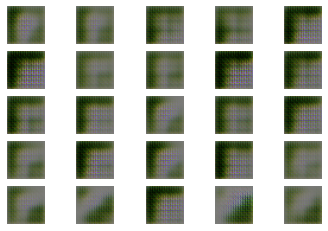

>6, 1/39, d1=0.512, d2=0.324 g=1.410
>6, 2/39, d1=1.072, d2=0.331 g=1.366
>6, 3/39, d1=0.832, d2=0.343 g=1.360
>6, 4/39, d1=0.935, d2=0.354 g=1.325
>6, 5/39, d1=0.868, d2=0.352 g=1.331
>6, 6/39, d1=0.798, d2=0.334 g=1.413
>6, 7/39, d1=0.848, d2=0.327 g=1.481
>6, 8/39, d1=0.996, d2=0.313 g=1.446
>6, 9/39, d1=0.786, d2=0.295 g=1.513
>6, 10/39, d1=0.746, d2=0.264 g=1.655
>6, 11/39, d1=0.856, d2=0.241 g=1.721
>6, 12/39, d1=0.786, d2=0.219 g=1.828
>6, 13/39, d1=0.761, d2=0.199 g=1.897
>6, 14/39, d1=1.010, d2=0.198 g=1.909
>6, 15/39, d1=0.814, d2=0.220 g=1.832
>6, 16/39, d1=0.729, d2=0.239 g=1.848
>6, 17/39, d1=0.761, d2=0.227 g=1.762
>6, 18/39, d1=0.888, d2=0.283 g=1.530
>6, 19/39, d1=0.872, d2=0.315 g=1.357
>6, 20/39, d1=0.714, d2=0.330 g=1.344
>6, 21/39, d1=0.648, d2=0.335 g=1.323
>6, 22/39, d1=0.684, d2=0.337 g=1.317
>6, 23/39, d1=0.744, d2=0.335 g=1.331
>6, 24/39, d1=0.662, d2=0.334 g=1.338
>6, 25/39, d1=0.669, d2=0.333 g=1.330
>6, 26/39, d1=0.641, d2=0.343 g=1.321
>6, 27/39, d1=0.564, 

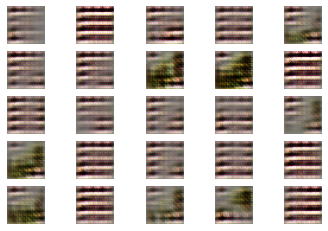

>11, 1/39, d1=0.334, d2=0.496 g=1.967
>11, 2/39, d1=0.402, d2=0.352 g=2.286
>11, 3/39, d1=0.341, d2=0.460 g=2.438
>11, 4/39, d1=0.393, d2=0.300 g=2.269
>11, 5/39, d1=0.225, d2=0.563 g=2.400
>11, 6/39, d1=0.619, d2=0.678 g=1.740
>11, 7/39, d1=0.554, d2=0.442 g=1.668
>11, 8/39, d1=0.400, d2=0.266 g=1.871
>11, 9/39, d1=0.407, d2=0.300 g=1.932
>11, 10/39, d1=0.330, d2=0.825 g=2.562
>11, 11/39, d1=0.779, d2=0.695 g=2.344
>11, 12/39, d1=0.747, d2=0.373 g=2.490
>11, 13/39, d1=0.733, d2=0.359 g=1.923
>11, 14/39, d1=0.533, d2=0.502 g=1.965
>11, 15/39, d1=0.732, d2=0.579 g=1.454
>11, 16/39, d1=0.711, d2=0.463 g=1.552
>11, 17/39, d1=0.515, d2=0.328 g=1.898
>11, 18/39, d1=0.385, d2=0.176 g=2.448
>11, 19/39, d1=0.585, d2=0.168 g=2.248
>11, 20/39, d1=0.305, d2=0.238 g=2.140
>11, 21/39, d1=0.303, d2=0.830 g=1.906
>11, 22/39, d1=0.530, d2=0.366 g=3.358
>11, 23/39, d1=0.862, d2=0.120 g=3.022
>11, 24/39, d1=0.694, d2=0.253 g=1.754
>11, 25/39, d1=0.516, d2=0.325 g=1.391
>11, 26/39, d1=0.323, d2=0.386 g=1

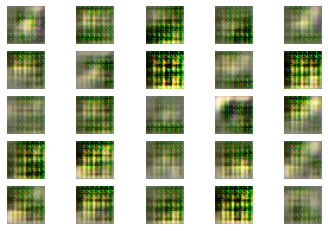

>16, 1/39, d1=0.479, d2=0.570 g=1.104
>16, 2/39, d1=0.428, d2=0.582 g=1.235
>16, 3/39, d1=0.449, d2=0.629 g=1.228
>16, 4/39, d1=0.558, d2=0.582 g=1.193
>16, 5/39, d1=0.613, d2=0.637 g=1.110
>16, 6/39, d1=0.606, d2=0.638 g=1.187
>16, 7/39, d1=0.590, d2=0.499 g=1.297
>16, 8/39, d1=0.545, d2=0.449 g=1.502
>16, 9/39, d1=0.510, d2=0.555 g=1.456
>16, 10/39, d1=0.462, d2=0.723 g=1.716
>16, 11/39, d1=0.602, d2=0.569 g=1.379
>16, 12/39, d1=0.513, d2=0.625 g=1.413
>16, 13/39, d1=0.457, d2=0.575 g=1.660
>16, 14/39, d1=0.440, d2=0.384 g=1.890
>16, 15/39, d1=0.510, d2=0.572 g=2.682
>16, 16/39, d1=0.979, d2=0.365 g=2.282
>16, 17/39, d1=0.928, d2=0.444 g=1.562
>16, 18/39, d1=0.467, d2=0.657 g=1.549
>16, 19/39, d1=0.342, d2=0.681 g=2.386
>16, 20/39, d1=0.862, d2=0.539 g=1.768
>16, 21/39, d1=0.580, d2=0.963 g=1.786
>16, 22/39, d1=0.897, d2=0.487 g=1.503
>16, 23/39, d1=0.872, d2=0.530 g=1.341
>16, 24/39, d1=0.742, d2=0.578 g=1.222
>16, 25/39, d1=0.753, d2=0.649 g=0.995
>16, 26/39, d1=0.672, d2=0.716 g=0

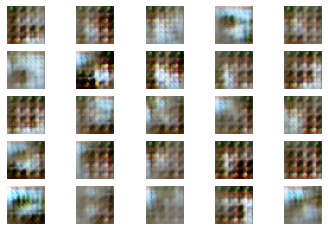

>21, 1/39, d1=0.449, d2=0.523 g=1.327
>21, 2/39, d1=0.443, d2=0.596 g=1.289
>21, 3/39, d1=0.475, d2=0.688 g=1.262
>21, 4/39, d1=0.496, d2=0.657 g=1.319
>21, 5/39, d1=0.655, d2=0.549 g=1.283
>21, 6/39, d1=0.636, d2=0.601 g=1.314
>21, 7/39, d1=0.582, d2=0.469 g=1.507
>21, 8/39, d1=0.620, d2=0.573 g=1.402
>21, 9/39, d1=0.663, d2=0.542 g=1.365
>21, 10/39, d1=0.621, d2=0.589 g=1.407
>21, 11/39, d1=0.757, d2=0.499 g=1.285
>21, 12/39, d1=0.717, d2=0.550 g=1.249
>21, 13/39, d1=0.597, d2=0.529 g=1.152
>21, 14/39, d1=0.595, d2=0.610 g=1.232
>21, 15/39, d1=0.596, d2=0.655 g=1.157
>21, 16/39, d1=0.617, d2=0.646 g=1.130
>21, 17/39, d1=0.527, d2=0.547 g=1.088
>21, 18/39, d1=0.499, d2=0.664 g=1.184
>21, 19/39, d1=0.542, d2=0.609 g=1.208
>21, 20/39, d1=0.585, d2=0.563 g=1.328
>21, 21/39, d1=0.553, d2=0.566 g=1.491
>21, 22/39, d1=0.539, d2=0.440 g=1.617
>21, 23/39, d1=0.490, d2=0.534 g=1.587
>21, 24/39, d1=0.661, d2=0.543 g=1.313
>21, 25/39, d1=0.501, d2=0.585 g=1.311
>21, 26/39, d1=0.431, d2=0.606 g=1

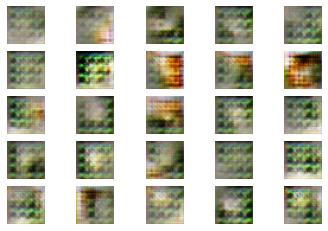

>26, 1/39, d1=0.472, d2=0.573 g=1.470
>26, 2/39, d1=0.570, d2=0.780 g=1.234
>26, 3/39, d1=0.751, d2=0.623 g=1.192
>26, 4/39, d1=0.736, d2=0.651 g=1.186
>26, 5/39, d1=0.740, d2=0.517 g=1.100
>26, 6/39, d1=0.684, d2=0.532 g=1.053
>26, 7/39, d1=0.587, d2=0.595 g=1.047
>26, 8/39, d1=0.681, d2=0.596 g=0.897
>26, 9/39, d1=0.571, d2=0.648 g=0.866
>26, 10/39, d1=0.513, d2=0.632 g=0.866
>26, 11/39, d1=0.492, d2=0.672 g=0.864
>26, 12/39, d1=0.497, d2=0.636 g=0.912
>26, 13/39, d1=0.531, d2=0.592 g=0.953
>26, 14/39, d1=0.553, d2=0.605 g=0.966
>26, 15/39, d1=0.505, d2=0.595 g=0.959
>26, 16/39, d1=0.478, d2=0.760 g=0.985
>26, 17/39, d1=0.579, d2=0.700 g=1.023
>26, 18/39, d1=0.681, d2=1.174 g=1.065
>26, 19/39, d1=0.692, d2=0.680 g=0.935
>26, 20/39, d1=0.662, d2=0.702 g=0.972
>26, 21/39, d1=0.730, d2=0.629 g=0.965
>26, 22/39, d1=0.770, d2=0.596 g=0.965
>26, 23/39, d1=0.664, d2=0.544 g=1.034
>26, 24/39, d1=0.646, d2=0.559 g=1.026
>26, 25/39, d1=0.581, d2=0.665 g=1.112
>26, 26/39, d1=0.589, d2=0.561 g=1

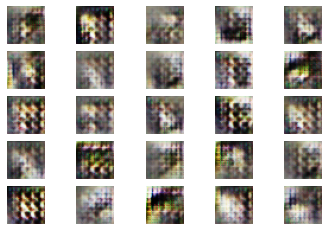

>31, 1/39, d1=0.577, d2=0.596 g=1.086
>31, 2/39, d1=0.650, d2=0.554 g=1.119
>31, 3/39, d1=0.682, d2=0.572 g=1.001
>31, 4/39, d1=0.624, d2=0.651 g=0.925
>31, 5/39, d1=0.601, d2=0.667 g=0.858
>31, 6/39, d1=0.608, d2=0.767 g=0.843
>31, 7/39, d1=0.614, d2=0.724 g=0.817
>31, 8/39, d1=0.700, d2=0.772 g=0.831
>31, 9/39, d1=0.767, d2=0.773 g=0.869
>31, 10/39, d1=0.715, d2=0.604 g=0.884
>31, 11/39, d1=0.688, d2=0.644 g=0.872
>31, 12/39, d1=0.739, d2=0.692 g=0.832
>31, 13/39, d1=0.666, d2=0.760 g=0.836
>31, 14/39, d1=0.648, d2=0.666 g=0.842
>31, 15/39, d1=0.701, d2=0.647 g=0.884
>31, 16/39, d1=0.711, d2=0.599 g=0.932
>31, 17/39, d1=0.724, d2=0.523 g=0.946
>31, 18/39, d1=0.614, d2=0.562 g=0.965
>31, 19/39, d1=0.683, d2=0.563 g=0.915
>31, 20/39, d1=0.639, d2=0.584 g=0.930
>31, 21/39, d1=0.546, d2=0.597 g=0.988
>31, 22/39, d1=0.515, d2=0.550 g=1.112
>31, 23/39, d1=0.519, d2=0.582 g=1.225
>31, 24/39, d1=0.531, d2=0.592 g=1.316
>31, 25/39, d1=0.674, d2=0.573 g=1.264
>31, 26/39, d1=0.545, d2=0.523 g=1

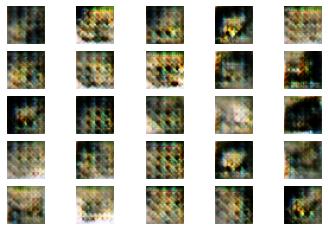

>36, 1/39, d1=0.614, d2=0.657 g=0.941
>36, 2/39, d1=0.609, d2=0.622 g=0.959
>36, 3/39, d1=0.619, d2=0.670 g=0.927
>36, 4/39, d1=0.627, d2=0.609 g=0.958
>36, 5/39, d1=0.664, d2=0.573 g=0.993
>36, 6/39, d1=0.634, d2=0.556 g=1.008
>36, 7/39, d1=0.602, d2=0.620 g=1.028
>36, 8/39, d1=0.591, d2=0.521 g=1.168
>36, 9/39, d1=0.560, d2=0.541 g=1.205
>36, 10/39, d1=0.621, d2=0.552 g=1.173
>36, 11/39, d1=0.682, d2=0.597 g=1.117
>36, 12/39, d1=0.636, d2=0.576 g=1.031
>36, 13/39, d1=0.713, d2=0.579 g=0.990
>36, 14/39, d1=0.714, d2=0.598 g=1.089
>36, 15/39, d1=0.698, d2=0.506 g=1.100
>36, 16/39, d1=0.633, d2=0.591 g=1.157
>36, 17/39, d1=0.541, d2=0.491 g=1.253
>36, 18/39, d1=0.595, d2=0.532 g=1.242
>36, 19/39, d1=0.495, d2=0.691 g=1.193
>36, 20/39, d1=0.558, d2=1.065 g=1.238
>36, 21/39, d1=0.775, d2=0.517 g=1.079
>36, 22/39, d1=0.772, d2=0.482 g=1.011
>36, 23/39, d1=0.618, d2=0.545 g=0.977
>36, 24/39, d1=0.501, d2=0.538 g=1.096
>36, 25/39, d1=0.452, d2=0.574 g=1.105
>36, 26/39, d1=0.499, d2=0.677 g=1

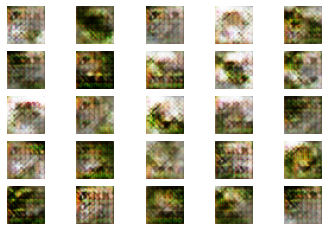

>41, 1/39, d1=0.568, d2=0.502 g=1.033
>41, 2/39, d1=0.691, d2=0.647 g=0.993
>41, 3/39, d1=0.625, d2=0.584 g=1.008
>41, 4/39, d1=0.680, d2=0.600 g=1.007
>41, 5/39, d1=0.676, d2=0.623 g=1.098
>41, 6/39, d1=0.582, d2=0.509 g=1.157
>41, 7/39, d1=0.782, d2=0.514 g=1.010
>41, 8/39, d1=0.643, d2=0.591 g=1.001
>41, 9/39, d1=0.513, d2=0.634 g=0.996
>41, 10/39, d1=0.566, d2=0.632 g=0.952
>41, 11/39, d1=0.554, d2=0.613 g=0.976
>41, 12/39, d1=0.655, d2=0.554 g=0.951
>41, 13/39, d1=0.608, d2=0.659 g=0.993
>41, 14/39, d1=0.611, d2=0.631 g=1.055
>41, 15/39, d1=0.590, d2=0.541 g=1.061
>41, 16/39, d1=0.636, d2=0.566 g=1.058
>41, 17/39, d1=0.498, d2=0.783 g=1.115
>41, 18/39, d1=0.422, d2=0.544 g=1.154
>41, 19/39, d1=0.543, d2=0.609 g=1.075
>41, 20/39, d1=0.513, d2=0.762 g=1.062
>41, 21/39, d1=0.617, d2=0.613 g=1.020
>41, 22/39, d1=0.701, d2=0.737 g=0.934
>41, 23/39, d1=0.671, d2=0.686 g=1.059
>41, 24/39, d1=0.681, d2=0.635 g=1.179
>41, 25/39, d1=0.746, d2=0.514 g=1.163
>41, 26/39, d1=0.704, d2=0.516 g=1

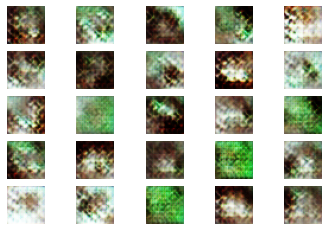

>46, 1/39, d1=0.626, d2=0.639 g=1.234
>46, 2/39, d1=0.666, d2=0.683 g=1.169
>46, 3/39, d1=0.692, d2=0.514 g=1.287
>46, 4/39, d1=0.672, d2=0.533 g=1.212
>46, 5/39, d1=0.493, d2=0.598 g=1.133
>46, 6/39, d1=0.448, d2=0.748 g=1.055
>46, 7/39, d1=0.538, d2=1.198 g=1.127
>46, 8/39, d1=0.720, d2=0.532 g=0.992
>46, 9/39, d1=0.651, d2=0.750 g=1.012
>46, 10/39, d1=0.596, d2=0.766 g=1.029
>46, 11/39, d1=0.590, d2=0.751 g=1.097
>46, 12/39, d1=0.604, d2=0.626 g=1.123
>46, 13/39, d1=0.687, d2=0.555 g=1.247
>46, 14/39, d1=0.796, d2=0.544 g=1.468
>46, 15/39, d1=0.781, d2=0.492 g=1.449
>46, 16/39, d1=0.670, d2=0.522 g=1.280
>46, 17/39, d1=0.686, d2=0.599 g=1.087
>46, 18/39, d1=0.640, d2=0.659 g=0.889
>46, 19/39, d1=0.645, d2=0.797 g=0.856
>46, 20/39, d1=0.588, d2=0.791 g=0.909
>46, 21/39, d1=0.652, d2=0.708 g=0.918
>46, 22/39, d1=0.614, d2=0.608 g=0.950
>46, 23/39, d1=0.570, d2=0.648 g=1.022
>46, 24/39, d1=0.550, d2=0.578 g=0.981
>46, 25/39, d1=0.526, d2=0.656 g=1.069
>46, 26/39, d1=0.483, d2=0.587 g=1

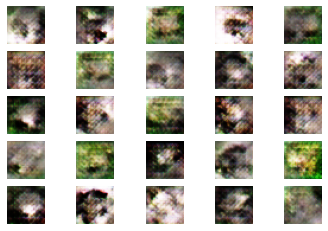

>51, 1/39, d1=0.568, d2=0.610 g=1.005
>51, 2/39, d1=0.610, d2=0.594 g=1.053
>51, 3/39, d1=0.611, d2=0.595 g=1.073
>51, 4/39, d1=0.592, d2=0.632 g=1.031
>51, 5/39, d1=0.613, d2=0.650 g=0.996
>51, 6/39, d1=0.623, d2=0.698 g=0.976
>51, 7/39, d1=0.592, d2=0.631 g=1.023
>51, 8/39, d1=0.666, d2=0.639 g=0.997
>51, 9/39, d1=0.636, d2=0.633 g=0.958
>51, 10/39, d1=0.765, d2=0.702 g=0.918
>51, 11/39, d1=0.674, d2=0.742 g=0.919
>51, 12/39, d1=0.663, d2=0.662 g=0.927
>51, 13/39, d1=0.729, d2=0.611 g=0.989
>51, 14/39, d1=0.721, d2=0.561 g=0.993
>51, 15/39, d1=0.721, d2=0.600 g=1.028
>51, 16/39, d1=0.623, d2=0.566 g=0.969
>51, 17/39, d1=0.629, d2=0.650 g=0.947
>51, 18/39, d1=0.590, d2=0.583 g=0.913
>51, 19/39, d1=0.546, d2=0.645 g=0.941
>51, 20/39, d1=0.481, d2=0.899 g=0.949
>51, 21/39, d1=0.574, d2=0.699 g=1.077
>51, 22/39, d1=0.708, d2=0.585 g=1.029
>51, 23/39, d1=0.780, d2=0.611 g=0.991
>51, 24/39, d1=0.669, d2=0.586 g=0.948
>51, 25/39, d1=0.687, d2=0.648 g=0.985
>51, 26/39, d1=0.678, d2=0.694 g=1

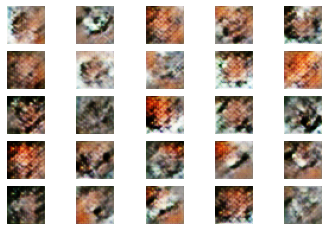

>56, 1/39, d1=0.543, d2=0.660 g=1.132
>56, 2/39, d1=0.639, d2=0.533 g=1.235
>56, 3/39, d1=0.601, d2=0.501 g=1.185
>56, 4/39, d1=0.670, d2=0.485 g=1.316
>56, 5/39, d1=0.598, d2=0.542 g=1.194
>56, 6/39, d1=0.512, d2=0.565 g=1.106
>56, 7/39, d1=0.500, d2=0.578 g=1.038
>56, 8/39, d1=0.529, d2=0.648 g=0.977
>56, 9/39, d1=0.520, d2=0.660 g=0.951
>56, 10/39, d1=0.619, d2=0.591 g=0.951
>56, 11/39, d1=0.515, d2=0.730 g=1.023
>56, 12/39, d1=0.494, d2=0.621 g=1.006
>56, 13/39, d1=0.527, d2=0.624 g=0.968
>56, 14/39, d1=0.475, d2=0.680 g=1.041
>56, 15/39, d1=0.457, d2=0.562 g=1.155
>56, 16/39, d1=0.581, d2=0.618 g=1.198
>56, 17/39, d1=0.523, d2=0.511 g=1.234
>56, 18/39, d1=0.670, d2=0.707 g=1.092
>56, 19/39, d1=0.473, d2=0.817 g=1.153
>56, 20/39, d1=0.575, d2=0.486 g=1.129
>56, 21/39, d1=0.524, d2=0.617 g=1.060
>56, 22/39, d1=0.392, d2=0.777 g=1.138
>56, 23/39, d1=0.463, d2=0.576 g=1.213
>56, 24/39, d1=0.565, d2=0.714 g=1.213
>56, 25/39, d1=0.629, d2=1.391 g=1.259
>56, 26/39, d1=0.953, d2=0.459 g=1

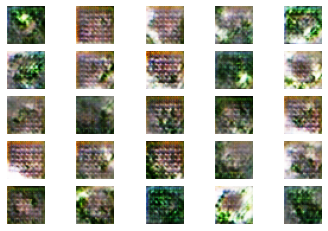

>61, 1/39, d1=0.615, d2=0.632 g=1.085
>61, 2/39, d1=0.574, d2=0.500 g=1.200
>61, 3/39, d1=0.616, d2=0.525 g=1.143
>61, 4/39, d1=0.502, d2=0.638 g=1.152
>61, 5/39, d1=0.505, d2=0.628 g=1.138
>61, 6/39, d1=0.516, d2=0.729 g=1.199
>61, 7/39, d1=0.532, d2=0.594 g=1.144
>61, 8/39, d1=0.666, d2=0.565 g=1.251
>61, 9/39, d1=0.611, d2=0.610 g=1.139
>61, 10/39, d1=0.646, d2=0.662 g=1.149
>61, 11/39, d1=0.604, d2=0.591 g=1.116
>61, 12/39, d1=0.707, d2=0.551 g=1.148
>61, 13/39, d1=0.651, d2=0.703 g=1.062
>61, 14/39, d1=0.610, d2=0.549 g=1.123
>61, 15/39, d1=0.633, d2=0.509 g=1.180
>61, 16/39, d1=0.613, d2=0.569 g=1.080
>61, 17/39, d1=0.637, d2=0.633 g=1.082
>61, 18/39, d1=0.558, d2=0.801 g=0.953
>61, 19/39, d1=0.531, d2=1.275 g=1.130
>61, 20/39, d1=0.709, d2=0.546 g=1.175
>61, 21/39, d1=0.558, d2=0.916 g=1.315
>61, 22/39, d1=0.759, d2=0.368 g=1.291
>61, 23/39, d1=0.708, d2=0.465 g=1.125
>61, 24/39, d1=0.763, d2=0.804 g=1.072
>61, 25/39, d1=0.627, d2=0.591 g=1.019
>61, 26/39, d1=0.635, d2=0.684 g=0

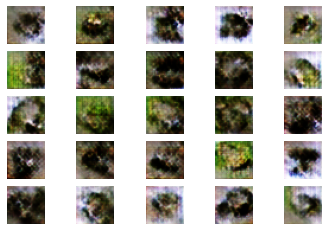

>66, 1/39, d1=0.541, d2=0.575 g=1.033
>66, 2/39, d1=0.550, d2=0.529 g=1.119
>66, 3/39, d1=0.495, d2=0.658 g=1.136
>66, 4/39, d1=0.531, d2=0.582 g=1.175
>66, 5/39, d1=0.570, d2=0.551 g=1.216
>66, 6/39, d1=0.532, d2=0.602 g=1.119
>66, 7/39, d1=0.685, d2=0.845 g=0.990
>66, 8/39, d1=0.784, d2=0.615 g=0.994
>66, 9/39, d1=0.655, d2=0.576 g=0.921
>66, 10/39, d1=0.537, d2=0.622 g=0.912
>66, 11/39, d1=0.480, d2=0.624 g=0.927
>66, 12/39, d1=0.362, d2=0.813 g=0.951
>66, 13/39, d1=0.456, d2=0.590 g=1.053
>66, 14/39, d1=0.390, d2=0.690 g=1.055
>66, 15/39, d1=0.378, d2=0.711 g=1.121
>66, 16/39, d1=0.435, d2=0.580 g=1.104
>66, 17/39, d1=0.547, d2=0.848 g=1.200
>66, 18/39, d1=0.782, d2=0.486 g=1.140
>66, 19/39, d1=0.880, d2=0.557 g=1.044
>66, 20/39, d1=0.754, d2=0.652 g=1.094
>66, 21/39, d1=0.773, d2=0.566 g=1.165
>66, 22/39, d1=0.685, d2=0.438 g=1.222
>66, 23/39, d1=0.790, d2=0.486 g=1.095
>66, 24/39, d1=0.620, d2=0.552 g=1.038
>66, 25/39, d1=0.660, d2=0.584 g=1.036
>66, 26/39, d1=0.588, d2=0.527 g=1

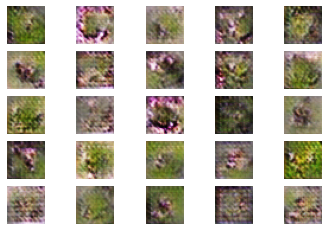

>71, 1/39, d1=0.511, d2=0.570 g=1.134
>71, 2/39, d1=0.646, d2=0.562 g=1.095
>71, 3/39, d1=0.725, d2=0.607 g=0.998
>71, 4/39, d1=0.611, d2=0.624 g=1.042
>71, 5/39, d1=0.486, d2=0.589 g=1.070
>71, 6/39, d1=0.495, d2=0.781 g=1.131
>71, 7/39, d1=0.598, d2=0.634 g=1.117
>71, 8/39, d1=0.762, d2=0.506 g=1.038
>71, 9/39, d1=0.696, d2=0.634 g=0.969
>71, 10/39, d1=0.682, d2=0.694 g=1.046
>71, 11/39, d1=0.655, d2=0.504 g=1.012
>71, 12/39, d1=0.685, d2=0.552 g=0.979
>71, 13/39, d1=0.560, d2=0.640 g=0.992
>71, 14/39, d1=0.658, d2=0.607 g=0.962
>71, 15/39, d1=0.546, d2=0.663 g=0.978
>71, 16/39, d1=0.545, d2=0.669 g=0.955
>71, 17/39, d1=0.611, d2=0.656 g=0.965
>71, 18/39, d1=0.602, d2=0.611 g=1.087
>71, 19/39, d1=0.684, d2=0.578 g=1.028
>71, 20/39, d1=0.660, d2=0.574 g=1.105
>71, 21/39, d1=0.615, d2=0.533 g=1.104
>71, 22/39, d1=0.560, d2=0.548 g=1.092
>71, 23/39, d1=0.587, d2=0.694 g=1.237
>71, 24/39, d1=0.638, d2=0.500 g=1.247
>71, 25/39, d1=0.556, d2=0.500 g=1.255
>71, 26/39, d1=0.545, d2=0.660 g=1

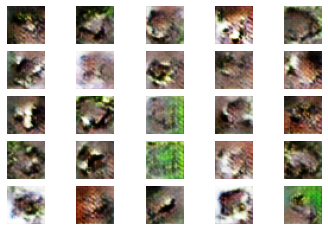

>76, 1/39, d1=0.561, d2=0.572 g=1.064
>76, 2/39, d1=0.777, d2=0.652 g=1.039
>76, 3/39, d1=0.718, d2=0.549 g=1.033
>76, 4/39, d1=0.615, d2=0.692 g=0.942
>76, 5/39, d1=0.669, d2=0.758 g=1.055
>76, 6/39, d1=0.590, d2=0.580 g=1.110
>76, 7/39, d1=0.647, d2=0.615 g=1.122
>76, 8/39, d1=0.585, d2=0.668 g=1.067
>76, 9/39, d1=0.513, d2=0.616 g=1.134
>76, 10/39, d1=0.664, d2=0.544 g=1.084
>76, 11/39, d1=0.489, d2=0.759 g=1.136
>76, 12/39, d1=0.660, d2=0.539 g=1.131
>76, 13/39, d1=0.641, d2=0.674 g=1.010
>76, 14/39, d1=0.581, d2=0.754 g=1.034
>76, 15/39, d1=0.768, d2=0.646 g=1.034
>76, 16/39, d1=0.650, d2=0.608 g=1.039
>76, 17/39, d1=0.747, d2=0.563 g=0.991
>76, 18/39, d1=0.722, d2=0.571 g=0.967
>76, 19/39, d1=0.673, d2=0.580 g=1.001
>76, 20/39, d1=0.670, d2=0.536 g=0.988
>76, 21/39, d1=0.590, d2=0.587 g=0.953
>76, 22/39, d1=0.633, d2=0.614 g=0.990
>76, 23/39, d1=0.598, d2=0.604 g=0.958
>76, 24/39, d1=0.668, d2=0.664 g=1.035
>76, 25/39, d1=0.581, d2=0.587 g=1.078
>76, 26/39, d1=0.637, d2=0.541 g=1

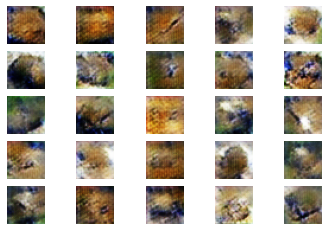

>81, 1/39, d1=0.548, d2=0.687 g=1.019
>81, 2/39, d1=0.638, d2=0.526 g=1.023
>81, 3/39, d1=0.611, d2=0.645 g=0.970
>81, 4/39, d1=0.661, d2=0.624 g=0.945
>81, 5/39, d1=0.650, d2=0.640 g=0.969
>81, 6/39, d1=0.632, d2=0.644 g=1.006
>81, 7/39, d1=0.634, d2=0.560 g=1.009
>81, 8/39, d1=0.678, d2=0.570 g=0.971
>81, 9/39, d1=0.625, d2=0.613 g=0.984
>81, 10/39, d1=0.627, d2=0.602 g=0.987
>81, 11/39, d1=0.627, d2=0.624 g=1.024
>81, 12/39, d1=0.606, d2=0.663 g=1.032
>81, 13/39, d1=0.597, d2=0.600 g=0.992
>81, 14/39, d1=0.603, d2=0.602 g=0.982
>81, 15/39, d1=0.592, d2=0.774 g=1.018
>81, 16/39, d1=0.585, d2=0.665 g=1.071
>81, 17/39, d1=0.664, d2=0.495 g=1.070
>81, 18/39, d1=0.701, d2=0.525 g=1.096
>81, 19/39, d1=0.696, d2=0.527 g=1.092
>81, 20/39, d1=0.698, d2=0.560 g=1.008
>81, 21/39, d1=0.619, d2=0.591 g=1.002
>81, 22/39, d1=0.669, d2=0.807 g=1.027
>81, 23/39, d1=0.714, d2=0.564 g=1.022
>81, 24/39, d1=0.686, d2=0.544 g=1.013
>81, 25/39, d1=0.612, d2=0.614 g=0.991
>81, 26/39, d1=0.595, d2=0.681 g=0

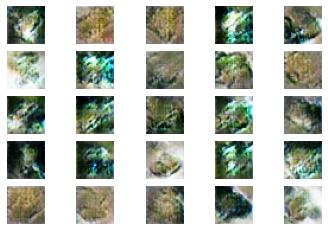

>86, 1/39, d1=0.546, d2=0.544 g=1.049
>86, 2/39, d1=0.695, d2=0.563 g=1.043
>86, 3/39, d1=0.653, d2=0.547 g=1.018
>86, 4/39, d1=0.638, d2=0.535 g=0.982
>86, 5/39, d1=0.548, d2=0.603 g=1.042
>86, 6/39, d1=0.603, d2=0.587 g=1.132
>86, 7/39, d1=0.454, d2=0.647 g=1.095
>86, 8/39, d1=0.479, d2=0.680 g=1.110
>86, 9/39, d1=0.540, d2=0.627 g=1.094
>86, 10/39, d1=0.537, d2=0.597 g=1.143
>86, 11/39, d1=0.554, d2=0.634 g=1.201
>86, 12/39, d1=0.655, d2=0.618 g=1.151
>86, 13/39, d1=0.674, d2=0.587 g=1.096
>86, 14/39, d1=0.565, d2=0.570 g=1.116
>86, 15/39, d1=0.589, d2=0.642 g=1.129
>86, 16/39, d1=0.631, d2=0.579 g=1.100
>86, 17/39, d1=0.697, d2=0.591 g=1.163
>86, 18/39, d1=0.686, d2=0.550 g=1.120
>86, 19/39, d1=0.691, d2=0.532 g=1.108
>86, 20/39, d1=0.634, d2=0.537 g=1.088
>86, 21/39, d1=0.483, d2=0.644 g=1.135
>86, 22/39, d1=0.650, d2=0.518 g=1.073
>86, 23/39, d1=0.582, d2=0.576 g=1.101
>86, 24/39, d1=0.503, d2=0.667 g=1.155
>86, 25/39, d1=0.602, d2=0.484 g=1.195
>86, 26/39, d1=0.664, d2=0.787 g=1

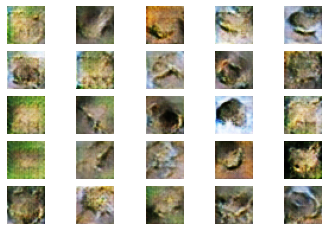

>91, 1/39, d1=0.536, d2=0.712 g=1.109
>91, 2/39, d1=0.622, d2=0.580 g=1.114
>91, 3/39, d1=0.674, d2=0.556 g=1.086
>91, 4/39, d1=0.715, d2=0.627 g=1.035
>91, 5/39, d1=0.704, d2=0.533 g=1.063
>91, 6/39, d1=0.650, d2=0.516 g=1.039
>91, 7/39, d1=0.698, d2=0.577 g=1.080
>91, 8/39, d1=0.643, d2=0.538 g=1.044
>91, 9/39, d1=0.700, d2=0.674 g=1.063
>91, 10/39, d1=0.586, d2=0.570 g=1.113
>91, 11/39, d1=0.658, d2=0.631 g=1.073
>91, 12/39, d1=0.672, d2=0.638 g=1.106
>91, 13/39, d1=0.661, d2=0.582 g=1.047
>91, 14/39, d1=0.659, d2=0.637 g=1.087
>91, 15/39, d1=0.625, d2=0.572 g=1.014
>91, 16/39, d1=0.485, d2=0.655 g=0.982
>91, 17/39, d1=0.534, d2=0.567 g=1.028
>91, 18/39, d1=0.495, d2=0.740 g=1.057
>91, 19/39, d1=0.620, d2=0.576 g=1.104
>91, 20/39, d1=0.492, d2=0.518 g=1.118
>91, 21/39, d1=0.589, d2=0.732 g=1.098
>91, 22/39, d1=0.685, d2=0.568 g=1.096
>91, 23/39, d1=0.644, d2=0.630 g=1.130
>91, 24/39, d1=0.633, d2=0.616 g=1.047
>91, 25/39, d1=0.619, d2=0.635 g=1.064
>91, 26/39, d1=0.505, d2=0.578 g=1

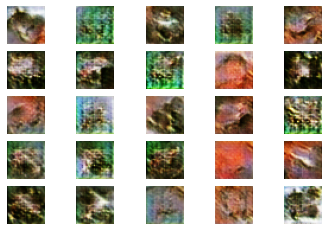

>96, 1/39, d1=0.510, d2=0.654 g=1.048
>96, 2/39, d1=0.588, d2=0.531 g=1.080
>96, 3/39, d1=0.609, d2=0.517 g=0.995
>96, 4/39, d1=0.517, d2=0.706 g=1.101
>96, 5/39, d1=0.533, d2=0.582 g=1.052
>96, 6/39, d1=0.586, d2=0.718 g=1.037
>96, 7/39, d1=0.566, d2=0.565 g=1.101
>96, 8/39, d1=0.542, d2=0.555 g=1.010
>96, 9/39, d1=0.492, d2=0.969 g=1.248
>96, 10/39, d1=0.719, d2=0.433 g=1.158
>96, 11/39, d1=0.777, d2=0.468 g=1.065
>96, 12/39, d1=0.738, d2=0.601 g=0.976
>96, 13/39, d1=0.642, d2=0.714 g=0.952
>96, 14/39, d1=0.641, d2=0.595 g=0.942
>96, 15/39, d1=0.646, d2=0.553 g=0.910
>96, 16/39, d1=0.606, d2=0.663 g=1.022
>96, 17/39, d1=0.628, d2=0.600 g=1.040
>96, 18/39, d1=0.556, d2=0.675 g=1.118
>96, 19/39, d1=0.676, d2=0.488 g=1.089
>96, 20/39, d1=0.618, d2=0.507 g=1.060
>96, 21/39, d1=0.631, d2=0.660 g=1.165
>96, 22/39, d1=0.630, d2=0.529 g=1.194
>96, 23/39, d1=0.635, d2=0.582 g=1.115
>96, 24/39, d1=0.620, d2=0.724 g=1.129
>96, 25/39, d1=0.735, d2=0.513 g=1.132
>96, 26/39, d1=0.758, d2=0.534 g=1

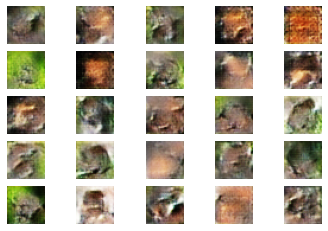

>101, 1/39, d1=0.555, d2=0.496 g=0.985
>101, 2/39, d1=0.690, d2=0.580 g=0.991
>101, 3/39, d1=0.752, d2=0.614 g=0.914
>101, 4/39, d1=0.628, d2=0.597 g=0.911
>101, 5/39, d1=0.697, d2=0.635 g=0.936
>101, 6/39, d1=0.663, d2=0.664 g=0.946
>101, 7/39, d1=0.630, d2=0.635 g=0.910
>101, 8/39, d1=0.746, d2=0.801 g=0.955
>101, 9/39, d1=0.688, d2=0.608 g=1.038
>101, 10/39, d1=0.737, d2=0.524 g=1.040
>101, 11/39, d1=0.685, d2=0.527 g=1.066
>101, 12/39, d1=0.728, d2=0.531 g=1.105
>101, 13/39, d1=0.704, d2=0.524 g=1.061
>101, 14/39, d1=0.637, d2=0.556 g=1.061
>101, 15/39, d1=0.653, d2=0.592 g=1.010
>101, 16/39, d1=0.592, d2=0.535 g=1.034
>101, 17/39, d1=0.584, d2=0.624 g=0.984
>101, 18/39, d1=0.574, d2=0.619 g=0.971
>101, 19/39, d1=0.595, d2=0.643 g=0.995
>101, 20/39, d1=0.603, d2=0.910 g=1.000
>101, 21/39, d1=0.678, d2=0.509 g=0.977
>101, 22/39, d1=0.792, d2=0.501 g=0.935
>101, 23/39, d1=0.689, d2=0.601 g=0.953
>101, 24/39, d1=0.718, d2=0.605 g=0.930
>101, 25/39, d1=0.586, d2=0.590 g=0.917
>101, 26/

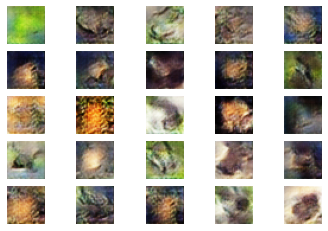

>106, 1/39, d1=0.596, d2=0.752 g=1.010
>106, 2/39, d1=0.725, d2=0.626 g=1.049
>106, 3/39, d1=0.849, d2=0.531 g=1.039
>106, 4/39, d1=0.731, d2=0.539 g=0.980
>106, 5/39, d1=0.638, d2=0.629 g=0.860
>106, 6/39, d1=0.630, d2=0.692 g=0.894
>106, 7/39, d1=0.534, d2=0.712 g=0.853
>106, 8/39, d1=0.639, d2=0.738 g=0.901
>106, 9/39, d1=0.616, d2=0.541 g=0.986
>106, 10/39, d1=0.625, d2=0.640 g=1.023
>106, 11/39, d1=0.630, d2=0.582 g=0.991
>106, 12/39, d1=0.584, d2=0.653 g=1.044
>106, 13/39, d1=0.615, d2=0.654 g=1.022
>106, 14/39, d1=0.648, d2=0.942 g=1.059
>106, 15/39, d1=0.804, d2=0.552 g=1.023
>106, 16/39, d1=0.730, d2=0.536 g=0.937
>106, 17/39, d1=0.784, d2=0.574 g=0.904
>106, 18/39, d1=0.650, d2=0.581 g=0.902
>106, 19/39, d1=0.653, d2=0.627 g=0.961
>106, 20/39, d1=0.651, d2=0.679 g=0.978
>106, 21/39, d1=0.674, d2=0.580 g=0.996
>106, 22/39, d1=0.695, d2=0.608 g=1.026
>106, 23/39, d1=0.587, d2=0.553 g=0.979
>106, 24/39, d1=0.642, d2=0.675 g=0.937
>106, 25/39, d1=0.545, d2=0.652 g=0.949
>106, 26/

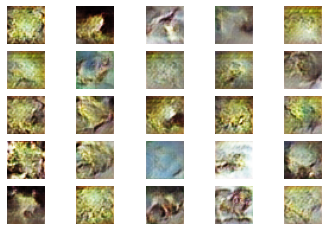

>111, 1/39, d1=0.541, d2=0.582 g=0.955
>111, 2/39, d1=0.562, d2=0.617 g=0.967
>111, 3/39, d1=0.631, d2=0.661 g=0.976
>111, 4/39, d1=0.597, d2=0.575 g=0.996
>111, 5/39, d1=0.656, d2=0.584 g=0.974
>111, 6/39, d1=0.555, d2=0.564 g=0.971
>111, 7/39, d1=0.540, d2=0.604 g=0.988
>111, 8/39, d1=0.599, d2=0.589 g=0.980
>111, 9/39, d1=0.567, d2=0.649 g=0.992
>111, 10/39, d1=0.560, d2=0.587 g=0.942
>111, 11/39, d1=0.668, d2=0.685 g=0.970
>111, 12/39, d1=0.531, d2=0.623 g=1.008
>111, 13/39, d1=0.575, d2=0.579 g=0.972
>111, 14/39, d1=0.697, d2=0.633 g=0.973
>111, 15/39, d1=0.705, d2=0.625 g=1.021
>111, 16/39, d1=0.683, d2=0.758 g=1.008
>111, 17/39, d1=0.713, d2=0.538 g=1.031
>111, 18/39, d1=0.764, d2=0.565 g=0.973
>111, 19/39, d1=0.720, d2=0.637 g=0.904
>111, 20/39, d1=0.739, d2=0.628 g=0.903
>111, 21/39, d1=0.741, d2=0.577 g=0.940
>111, 22/39, d1=0.716, d2=0.601 g=0.910
>111, 23/39, d1=0.706, d2=0.568 g=0.978
>111, 24/39, d1=0.667, d2=0.570 g=1.000
>111, 25/39, d1=0.607, d2=0.568 g=0.964
>111, 26/

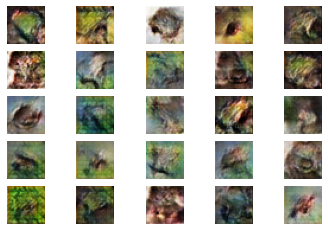

>116, 1/39, d1=0.572, d2=0.605 g=0.905
>116, 2/39, d1=0.498, d2=0.709 g=0.953
>116, 3/39, d1=0.522, d2=0.604 g=0.976
>116, 4/39, d1=0.631, d2=0.656 g=0.968
>116, 5/39, d1=0.606, d2=0.629 g=0.990
>116, 6/39, d1=0.581, d2=0.607 g=0.963
>116, 7/39, d1=0.616, d2=0.673 g=0.959
>116, 8/39, d1=0.588, d2=0.650 g=0.936
>116, 9/39, d1=0.599, d2=0.625 g=0.960
>116, 10/39, d1=0.649, d2=0.740 g=1.014
>116, 11/39, d1=0.723, d2=0.627 g=1.032
>116, 12/39, d1=0.718, d2=0.604 g=1.017
>116, 13/39, d1=0.748, d2=0.535 g=0.988
>116, 14/39, d1=0.737, d2=0.547 g=0.971
>116, 15/39, d1=0.659, d2=0.594 g=0.917
>116, 16/39, d1=0.617, d2=0.716 g=0.973
>116, 17/39, d1=0.637, d2=0.634 g=0.953
>116, 18/39, d1=0.630, d2=0.654 g=0.946
>116, 19/39, d1=0.641, d2=0.611 g=0.963
>116, 20/39, d1=0.677, d2=0.671 g=0.896
>116, 21/39, d1=0.625, d2=0.892 g=1.007
>116, 22/39, d1=0.781, d2=0.544 g=0.945
>116, 23/39, d1=0.681, d2=0.546 g=0.922
>116, 24/39, d1=0.700, d2=0.585 g=0.885
>116, 25/39, d1=0.598, d2=0.596 g=0.879
>116, 26/

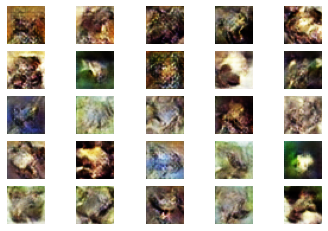

>121, 1/39, d1=0.566, d2=0.529 g=0.933
>121, 2/39, d1=0.637, d2=0.682 g=0.967
>121, 3/39, d1=0.603, d2=0.604 g=0.973
>121, 4/39, d1=0.626, d2=0.589 g=0.986
>121, 5/39, d1=0.663, d2=0.598 g=0.972
>121, 6/39, d1=0.575, d2=0.575 g=0.963
>121, 7/39, d1=0.505, d2=0.618 g=0.947
>121, 8/39, d1=0.633, d2=0.609 g=0.965
>121, 9/39, d1=0.603, d2=0.661 g=1.028
>121, 10/39, d1=0.789, d2=0.598 g=0.931
>121, 11/39, d1=0.644, d2=0.706 g=1.002
>121, 12/39, d1=0.723, d2=0.543 g=0.934
>121, 13/39, d1=0.644, d2=0.609 g=0.897
>121, 14/39, d1=0.682, d2=0.614 g=0.881
>121, 15/39, d1=0.532, d2=0.642 g=0.891
>121, 16/39, d1=0.571, d2=0.649 g=0.937
>121, 17/39, d1=0.623, d2=0.591 g=1.024
>121, 18/39, d1=0.700, d2=0.682 g=1.017
>121, 19/39, d1=0.674, d2=0.644 g=0.936
>121, 20/39, d1=0.587, d2=0.609 g=0.950
>121, 21/39, d1=0.706, d2=0.641 g=0.995
>121, 22/39, d1=0.646, d2=0.620 g=0.953
>121, 23/39, d1=0.627, d2=0.585 g=0.950
>121, 24/39, d1=0.633, d2=0.629 g=1.051
>121, 25/39, d1=0.653, d2=0.551 g=1.061
>121, 26/

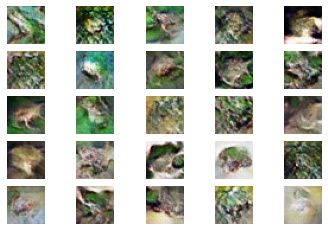

>126, 1/39, d1=0.559, d2=0.618 g=0.923
>126, 2/39, d1=0.652, d2=0.711 g=0.937
>126, 3/39, d1=0.650, d2=0.607 g=0.977
>126, 4/39, d1=0.722, d2=0.631 g=0.960
>126, 5/39, d1=0.593, d2=0.575 g=0.945
>126, 6/39, d1=0.641, d2=0.563 g=1.011
>126, 7/39, d1=0.630, d2=0.583 g=1.025
>126, 8/39, d1=0.619, d2=0.592 g=0.960
>126, 9/39, d1=0.676, d2=0.640 g=1.034
>126, 10/39, d1=0.632, d2=0.585 g=1.049
>126, 11/39, d1=0.695, d2=0.554 g=1.093
>126, 12/39, d1=0.679, d2=0.576 g=1.133
>126, 13/39, d1=0.622, d2=0.569 g=1.062
>126, 14/39, d1=0.649, d2=0.553 g=1.017
>126, 15/39, d1=0.619, d2=0.651 g=0.909
>126, 16/39, d1=0.633, d2=0.725 g=0.878
>126, 17/39, d1=0.667, d2=0.642 g=0.874
>126, 18/39, d1=0.577, d2=0.794 g=0.877
>126, 19/39, d1=0.760, d2=0.694 g=0.858
>126, 20/39, d1=0.653, d2=0.666 g=0.846
>126, 21/39, d1=0.691, d2=0.681 g=0.890
>126, 22/39, d1=0.689, d2=0.616 g=0.901
>126, 23/39, d1=0.668, d2=0.611 g=0.937
>126, 24/39, d1=0.709, d2=0.551 g=1.008
>126, 25/39, d1=0.636, d2=0.570 g=1.016
>126, 26/

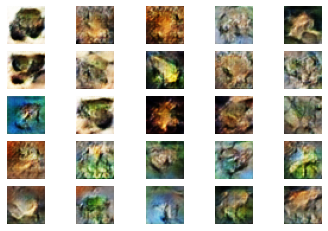

>131, 1/39, d1=0.527, d2=0.678 g=0.924
>131, 2/39, d1=0.675, d2=0.582 g=0.990
>131, 3/39, d1=0.673, d2=0.680 g=0.963
>131, 4/39, d1=0.680, d2=0.645 g=0.991
>131, 5/39, d1=0.626, d2=0.565 g=0.995
>131, 6/39, d1=0.648, d2=0.549 g=0.943
>131, 7/39, d1=0.527, d2=0.638 g=0.887
>131, 8/39, d1=0.631, d2=0.663 g=0.927
>131, 9/39, d1=0.537, d2=0.742 g=0.958
>131, 10/39, d1=0.646, d2=0.580 g=0.990
>131, 11/39, d1=0.755, d2=0.652 g=0.995
>131, 12/39, d1=0.720, d2=0.524 g=0.977
>131, 13/39, d1=0.748, d2=0.578 g=0.944
>131, 14/39, d1=0.653, d2=0.655 g=0.886
>131, 15/39, d1=0.555, d2=0.683 g=0.941
>131, 16/39, d1=0.564, d2=0.709 g=0.924
>131, 17/39, d1=0.592, d2=0.677 g=1.007
>131, 18/39, d1=0.633, d2=0.571 g=0.973
>131, 19/39, d1=0.535, d2=0.575 g=0.971
>131, 20/39, d1=0.547, d2=0.853 g=1.010
>131, 21/39, d1=0.678, d2=0.517 g=0.980
>131, 22/39, d1=0.586, d2=0.548 g=0.948
>131, 23/39, d1=0.605, d2=0.613 g=0.886
>131, 24/39, d1=0.643, d2=0.670 g=0.936
>131, 25/39, d1=0.487, d2=0.685 g=0.951
>131, 26/

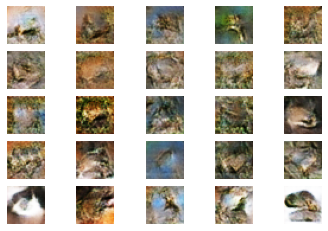

>136, 1/39, d1=0.569, d2=0.607 g=0.972
>136, 2/39, d1=0.691, d2=0.616 g=0.920
>136, 3/39, d1=0.564, d2=0.667 g=0.979
>136, 4/39, d1=0.635, d2=0.729 g=0.987
>136, 5/39, d1=0.645, d2=0.590 g=1.020
>136, 6/39, d1=0.666, d2=0.567 g=1.006
>136, 7/39, d1=0.579, d2=0.593 g=1.011
>136, 8/39, d1=0.608, d2=0.638 g=0.937
>136, 9/39, d1=0.633, d2=0.619 g=1.010
>136, 10/39, d1=0.628, d2=0.582 g=0.977
>136, 11/39, d1=0.696, d2=0.597 g=0.921
>136, 12/39, d1=0.696, d2=0.589 g=0.936
>136, 13/39, d1=0.630, d2=0.835 g=0.916
>136, 14/39, d1=0.659, d2=0.729 g=0.968
>136, 15/39, d1=0.684, d2=0.598 g=0.975
>136, 16/39, d1=0.764, d2=0.609 g=0.960
>136, 17/39, d1=0.734, d2=0.696 g=0.992
>136, 18/39, d1=0.654, d2=0.583 g=1.022
>136, 19/39, d1=0.666, d2=0.539 g=1.076
>136, 20/39, d1=0.723, d2=0.553 g=1.048
>136, 21/39, d1=0.701, d2=0.553 g=1.019
>136, 22/39, d1=0.622, d2=0.624 g=0.952
>136, 23/39, d1=0.575, d2=0.590 g=1.047
>136, 24/39, d1=0.738, d2=0.595 g=0.954
>136, 25/39, d1=0.637, d2=0.584 g=1.000
>136, 26/

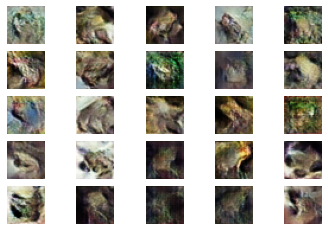

>141, 1/39, d1=0.567, d2=0.583 g=1.027
>141, 2/39, d1=0.529, d2=0.623 g=0.984
>141, 3/39, d1=0.727, d2=0.638 g=0.952
>141, 4/39, d1=0.585, d2=0.645 g=1.021
>141, 5/39, d1=0.647, d2=0.570 g=1.019
>141, 6/39, d1=0.691, d2=0.547 g=0.995
>141, 7/39, d1=0.577, d2=0.601 g=0.943
>141, 8/39, d1=0.539, d2=0.688 g=1.016
>141, 9/39, d1=0.566, d2=0.609 g=0.997
>141, 10/39, d1=0.631, d2=0.734 g=1.006
>141, 11/39, d1=0.599, d2=0.554 g=1.031
>141, 12/39, d1=0.691, d2=0.610 g=1.042
>141, 13/39, d1=0.645, d2=0.611 g=1.068
>141, 14/39, d1=0.593, d2=0.582 g=1.133
>141, 15/39, d1=0.683, d2=0.536 g=1.053
>141, 16/39, d1=0.668, d2=0.779 g=1.005
>141, 17/39, d1=0.630, d2=0.547 g=0.972
>141, 18/39, d1=0.656, d2=0.653 g=0.988
>141, 19/39, d1=0.712, d2=0.552 g=1.013
>141, 20/39, d1=0.627, d2=0.571 g=1.075
>141, 21/39, d1=0.605, d2=0.577 g=0.960
>141, 22/39, d1=0.641, d2=0.804 g=0.985
>141, 23/39, d1=0.656, d2=0.654 g=0.959
>141, 24/39, d1=0.579, d2=0.603 g=0.987
>141, 25/39, d1=0.636, d2=0.558 g=1.011
>141, 26/

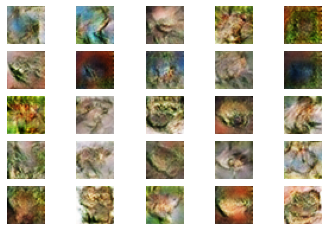

>146, 1/39, d1=0.567, d2=0.649 g=0.954
>146, 2/39, d1=0.624, d2=0.679 g=0.983
>146, 3/39, d1=0.691, d2=0.672 g=1.002
>146, 4/39, d1=0.643, d2=0.607 g=1.015
>146, 5/39, d1=0.602, d2=0.611 g=1.016
>146, 6/39, d1=0.651, d2=0.618 g=1.016
>146, 7/39, d1=0.596, d2=0.704 g=1.062
>146, 8/39, d1=0.645, d2=0.572 g=1.054
>146, 9/39, d1=0.636, d2=0.536 g=1.001
>146, 10/39, d1=0.614, d2=0.609 g=0.985
>146, 11/39, d1=0.566, d2=0.676 g=0.974
>146, 12/39, d1=0.519, d2=0.641 g=1.012
>146, 13/39, d1=0.719, d2=0.629 g=0.982
>146, 14/39, d1=0.602, d2=0.577 g=1.015
>146, 15/39, d1=0.518, d2=0.593 g=1.041
>146, 16/39, d1=0.608, d2=0.667 g=1.069
>146, 17/39, d1=0.614, d2=0.580 g=1.051
>146, 18/39, d1=0.596, d2=0.717 g=1.024
>146, 19/39, d1=0.728, d2=0.560 g=1.011
>146, 20/39, d1=0.771, d2=0.507 g=0.970
>146, 21/39, d1=0.660, d2=0.567 g=0.969
>146, 22/39, d1=0.579, d2=0.645 g=0.993
>146, 23/39, d1=0.641, d2=0.610 g=0.963
>146, 24/39, d1=0.556, d2=0.628 g=0.994
>146, 25/39, d1=0.529, d2=0.759 g=0.952
>146, 26/

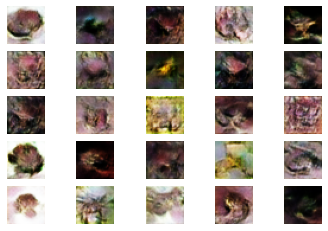

>151, 1/39, d1=0.569, d2=0.682 g=1.063
>151, 2/39, d1=0.662, d2=0.536 g=1.091
>151, 3/39, d1=0.737, d2=0.493 g=1.041
>151, 4/39, d1=0.674, d2=0.555 g=1.067
>151, 5/39, d1=0.590, d2=0.610 g=1.010
>151, 6/39, d1=0.649, d2=0.624 g=1.044
>151, 7/39, d1=0.636, d2=0.547 g=1.026
>151, 8/39, d1=0.512, d2=0.549 g=1.018
>151, 9/39, d1=0.533, d2=0.601 g=1.130
>151, 10/39, d1=0.535, d2=0.673 g=1.122
>151, 11/39, d1=0.569, d2=0.668 g=1.056
>151, 12/39, d1=0.607, d2=0.542 g=1.153
>151, 13/39, d1=0.694, d2=0.598 g=1.086
>151, 14/39, d1=0.664, d2=0.584 g=1.093
>151, 15/39, d1=0.563, d2=0.545 g=1.087
>151, 16/39, d1=0.500, d2=0.599 g=1.104
>151, 17/39, d1=0.586, d2=0.556 g=1.027
>151, 18/39, d1=0.604, d2=0.798 g=0.999
>151, 19/39, d1=0.656, d2=0.670 g=0.953
>151, 20/39, d1=0.660, d2=0.832 g=1.123
>151, 21/39, d1=0.762, d2=0.537 g=1.101
>151, 22/39, d1=0.561, d2=0.550 g=1.160
>151, 23/39, d1=0.610, d2=0.661 g=1.158
>151, 24/39, d1=0.585, d2=0.564 g=1.076
>151, 25/39, d1=0.646, d2=0.638 g=1.022
>151, 26/

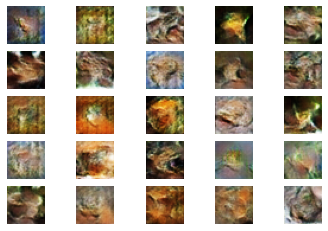

>156, 1/39, d1=0.487, d2=0.674 g=1.166
>156, 2/39, d1=0.613, d2=0.585 g=1.138
>156, 3/39, d1=0.670, d2=0.520 g=1.219
>156, 4/39, d1=0.576, d2=0.448 g=1.189
>156, 5/39, d1=0.709, d2=0.683 g=1.128
>156, 6/39, d1=0.571, d2=0.542 g=1.206
>156, 7/39, d1=0.548, d2=0.546 g=1.210
>156, 8/39, d1=0.599, d2=0.540 g=1.123
>156, 9/39, d1=0.420, d2=0.690 g=1.107
>156, 10/39, d1=0.499, d2=1.298 g=1.179
>156, 11/39, d1=0.842, d2=0.448 g=1.145
>156, 12/39, d1=0.812, d2=0.524 g=1.015
>156, 13/39, d1=0.742, d2=0.560 g=0.977
>156, 14/39, d1=0.618, d2=0.747 g=0.998
>156, 15/39, d1=0.661, d2=0.575 g=1.075
>156, 16/39, d1=0.587, d2=0.604 g=1.121
>156, 17/39, d1=0.686, d2=0.634 g=1.061
>156, 18/39, d1=0.575, d2=0.557 g=1.043
>156, 19/39, d1=0.646, d2=0.575 g=1.056
>156, 20/39, d1=0.637, d2=0.593 g=0.963
>156, 21/39, d1=0.534, d2=0.663 g=1.092
>156, 22/39, d1=0.562, d2=0.612 g=1.146
>156, 23/39, d1=0.585, d2=0.556 g=1.171
>156, 24/39, d1=0.687, d2=0.524 g=1.183
>156, 25/39, d1=0.607, d2=0.537 g=1.097
>156, 26/

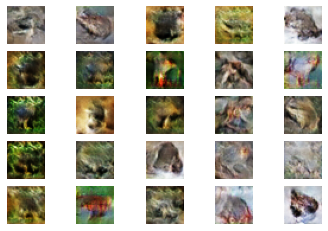

>161, 1/39, d1=0.552, d2=0.581 g=1.088
>161, 2/39, d1=0.592, d2=0.649 g=1.146
>161, 3/39, d1=0.753, d2=0.542 g=1.180
>161, 4/39, d1=0.727, d2=0.559 g=1.113
>161, 5/39, d1=0.657, d2=0.551 g=1.041
>161, 6/39, d1=0.593, d2=0.659 g=1.008
>161, 7/39, d1=0.537, d2=0.539 g=1.038
>161, 8/39, d1=0.628, d2=0.630 g=1.049
>161, 9/39, d1=0.644, d2=0.597 g=1.050
>161, 10/39, d1=0.638, d2=0.648 g=1.059
>161, 11/39, d1=0.582, d2=0.583 g=1.068
>161, 12/39, d1=0.538, d2=0.583 g=1.025
>161, 13/39, d1=0.523, d2=0.612 g=1.059
>161, 14/39, d1=0.447, d2=0.618 g=1.115
>161, 15/39, d1=0.458, d2=0.623 g=1.123
>161, 16/39, d1=0.620, d2=0.683 g=1.060
>161, 17/39, d1=0.462, d2=0.517 g=1.144
>161, 18/39, d1=0.544, d2=0.710 g=1.247
>161, 19/39, d1=0.648, d2=0.497 g=1.197
>161, 20/39, d1=0.672, d2=0.530 g=1.274
>161, 21/39, d1=0.699, d2=0.551 g=1.215
>161, 22/39, d1=0.702, d2=0.563 g=1.018
>161, 23/39, d1=0.678, d2=0.721 g=1.050
>161, 24/39, d1=0.614, d2=0.498 g=1.149
>161, 25/39, d1=0.725, d2=0.527 g=1.124
>161, 26/

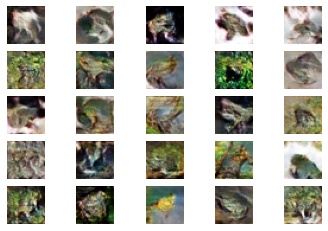

>166, 1/39, d1=0.589, d2=0.686 g=1.093
>166, 2/39, d1=0.592, d2=0.578 g=1.076
>166, 3/39, d1=0.627, d2=0.614 g=1.092
>166, 4/39, d1=0.560, d2=0.642 g=1.112
>166, 5/39, d1=0.528, d2=0.585 g=1.118
>166, 6/39, d1=0.567, d2=0.604 g=1.256
>166, 7/39, d1=0.529, d2=0.548 g=1.217
>166, 8/39, d1=0.564, d2=0.639 g=1.210
>166, 9/39, d1=0.691, d2=0.453 g=1.166
>166, 10/39, d1=0.658, d2=0.609 g=1.123
>166, 11/39, d1=0.577, d2=0.596 g=1.103
>166, 12/39, d1=0.577, d2=0.562 g=1.069
>166, 13/39, d1=0.589, d2=0.639 g=1.055
>166, 14/39, d1=0.619, d2=0.522 g=1.069
>166, 15/39, d1=0.682, d2=0.619 g=0.995
>166, 16/39, d1=0.511, d2=0.726 g=1.048
>166, 17/39, d1=0.376, d2=0.536 g=1.159
>166, 18/39, d1=0.525, d2=0.604 g=1.227
>166, 19/39, d1=0.637, d2=0.537 g=1.186
>166, 20/39, d1=0.642, d2=0.548 g=1.154
>166, 21/39, d1=0.556, d2=0.528 g=1.109
>166, 22/39, d1=0.654, d2=0.627 g=1.075
>166, 23/39, d1=0.547, d2=0.640 g=1.146
>166, 24/39, d1=0.652, d2=0.528 g=1.150
>166, 25/39, d1=0.541, d2=0.552 g=1.133
>166, 26/

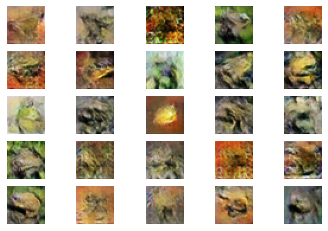

>171, 1/39, d1=0.500, d2=0.481 g=1.207
>171, 2/39, d1=0.561, d2=0.578 g=1.127
>171, 3/39, d1=0.549, d2=0.570 g=1.118
>171, 4/39, d1=0.541, d2=0.586 g=1.122
>171, 5/39, d1=0.576, d2=0.593 g=1.149
>171, 6/39, d1=0.602, d2=0.563 g=1.215
>171, 7/39, d1=0.557, d2=0.552 g=1.210
>171, 8/39, d1=0.581, d2=0.510 g=1.237
>171, 9/39, d1=0.521, d2=0.490 g=1.195
>171, 10/39, d1=0.540, d2=0.578 g=1.151
>171, 11/39, d1=0.589, d2=0.576 g=1.231
>171, 12/39, d1=0.573, d2=0.495 g=1.276
>171, 13/39, d1=0.600, d2=0.495 g=1.205
>171, 14/39, d1=0.430, d2=0.621 g=1.248
>171, 15/39, d1=0.555, d2=0.639 g=1.288
>171, 16/39, d1=0.667, d2=0.570 g=1.250
>171, 17/39, d1=0.574, d2=0.556 g=1.214
>171, 18/39, d1=0.586, d2=0.579 g=1.176
>171, 19/39, d1=0.583, d2=0.523 g=1.167
>171, 20/39, d1=0.559, d2=0.783 g=1.138
>171, 21/39, d1=0.588, d2=0.767 g=1.191
>171, 22/39, d1=0.696, d2=0.457 g=1.195
>171, 23/39, d1=0.585, d2=0.503 g=1.165
>171, 24/39, d1=0.600, d2=0.533 g=1.104
>171, 25/39, d1=0.572, d2=0.788 g=1.226
>171, 26/

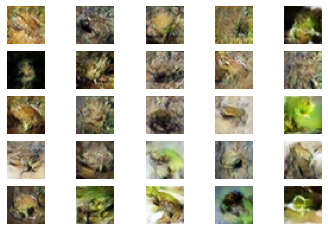

>176, 1/39, d1=0.506, d2=0.544 g=1.096
>176, 2/39, d1=0.514, d2=0.602 g=1.100
>176, 3/39, d1=0.508, d2=0.637 g=1.205
>176, 4/39, d1=0.522, d2=0.505 g=1.171
>176, 5/39, d1=0.630, d2=0.571 g=1.160
>176, 6/39, d1=0.496, d2=0.517 g=1.320
>176, 7/39, d1=0.579, d2=0.558 g=1.279
>176, 8/39, d1=0.577, d2=0.476 g=1.371
>176, 9/39, d1=0.546, d2=0.556 g=1.263
>176, 10/39, d1=0.580, d2=0.648 g=1.264
>176, 11/39, d1=0.673, d2=0.545 g=1.218
>176, 12/39, d1=0.639, d2=0.616 g=1.223
>176, 13/39, d1=0.751, d2=0.480 g=1.185
>176, 14/39, d1=0.574, d2=0.583 g=1.144
>176, 15/39, d1=0.588, d2=0.515 g=1.132
>176, 16/39, d1=0.470, d2=0.592 g=1.206
>176, 17/39, d1=0.499, d2=0.571 g=1.221
>176, 18/39, d1=0.537, d2=0.714 g=1.183
>176, 19/39, d1=0.585, d2=0.601 g=1.176
>176, 20/39, d1=0.512, d2=0.630 g=1.148
>176, 21/39, d1=0.599, d2=0.609 g=1.069
>176, 22/39, d1=0.589, d2=0.631 g=1.171
>176, 23/39, d1=0.536, d2=0.526 g=1.189
>176, 24/39, d1=0.610, d2=0.548 g=1.305
>176, 25/39, d1=0.596, d2=0.528 g=1.285
>176, 26/

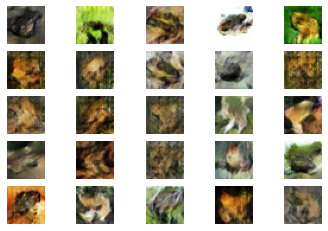

>181, 1/39, d1=0.491, d2=0.530 g=1.202
>181, 2/39, d1=0.619, d2=0.613 g=1.180
>181, 3/39, d1=0.519, d2=0.556 g=1.162
>181, 4/39, d1=0.571, d2=0.558 g=1.144
>181, 5/39, d1=0.539, d2=0.565 g=1.203
>181, 6/39, d1=0.500, d2=0.573 g=1.144
>181, 7/39, d1=0.520, d2=0.504 g=1.108
>181, 8/39, d1=0.463, d2=0.843 g=1.212
>181, 9/39, d1=0.592, d2=0.478 g=1.290
>181, 10/39, d1=0.640, d2=0.430 g=1.257
>181, 11/39, d1=0.459, d2=0.507 g=1.225
>181, 12/39, d1=0.409, d2=0.676 g=1.166
>181, 13/39, d1=0.557, d2=0.761 g=1.233
>181, 14/39, d1=0.701, d2=0.486 g=1.285
>181, 15/39, d1=0.738, d2=0.590 g=1.209
>181, 16/39, d1=0.683, d2=0.493 g=1.197
>181, 17/39, d1=0.597, d2=0.533 g=1.114
>181, 18/39, d1=0.513, d2=0.605 g=1.175
>181, 19/39, d1=0.597, d2=0.513 g=1.205
>181, 20/39, d1=0.476, d2=0.588 g=1.401
>181, 21/39, d1=0.494, d2=0.598 g=1.414
>181, 22/39, d1=0.579, d2=0.440 g=1.369
>181, 23/39, d1=0.540, d2=0.446 g=1.153
>181, 24/39, d1=0.586, d2=0.624 g=1.149
>181, 25/39, d1=0.566, d2=0.593 g=1.246
>181, 26/

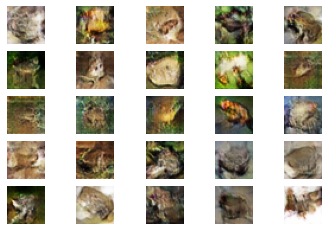

>186, 1/39, d1=0.495, d2=0.572 g=1.098
>186, 2/39, d1=0.470, d2=0.569 g=1.184
>186, 3/39, d1=0.651, d2=0.583 g=1.145
>186, 4/39, d1=0.575, d2=0.557 g=1.092
>186, 5/39, d1=0.703, d2=0.472 g=1.122
>186, 6/39, d1=0.553, d2=0.537 g=1.147
>186, 7/39, d1=0.493, d2=0.537 g=1.138
>186, 8/39, d1=0.437, d2=0.563 g=1.077
>186, 9/39, d1=0.524, d2=0.643 g=1.313
>186, 10/39, d1=0.714, d2=0.532 g=1.109
>186, 11/39, d1=0.454, d2=0.501 g=1.146
>186, 12/39, d1=0.536, d2=0.549 g=1.155
>186, 13/39, d1=0.657, d2=0.586 g=1.268
>186, 14/39, d1=0.488, d2=0.560 g=1.277
>186, 15/39, d1=0.518, d2=0.437 g=1.367
>186, 16/39, d1=0.469, d2=0.664 g=1.332
>186, 17/39, d1=0.600, d2=0.711 g=1.336
>186, 18/39, d1=0.754, d2=0.460 g=1.207
>186, 19/39, d1=0.726, d2=0.493 g=1.295
>186, 20/39, d1=0.655, d2=0.546 g=1.145
>186, 21/39, d1=0.609, d2=0.603 g=1.173
>186, 22/39, d1=0.490, d2=0.519 g=1.147
>186, 23/39, d1=0.464, d2=0.729 g=1.250
>186, 24/39, d1=0.599, d2=0.490 g=1.283
>186, 25/39, d1=0.458, d2=0.633 g=1.393
>186, 26/

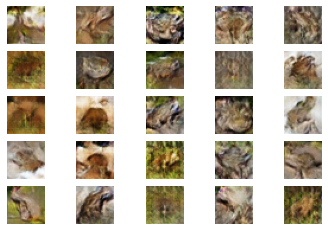

>191, 1/39, d1=0.459, d2=0.544 g=1.206
>191, 2/39, d1=0.436, d2=0.521 g=1.171
>191, 3/39, d1=0.499, d2=0.835 g=1.329
>191, 4/39, d1=0.725, d2=0.824 g=1.351
>191, 5/39, d1=0.722, d2=0.448 g=1.317
>191, 6/39, d1=0.620, d2=0.466 g=1.354
>191, 7/39, d1=0.631, d2=0.506 g=1.214
>191, 8/39, d1=0.586, d2=0.562 g=1.198
>191, 9/39, d1=0.474, d2=0.609 g=1.204
>191, 10/39, d1=0.425, d2=0.630 g=1.279
>191, 11/39, d1=0.505, d2=0.573 g=1.333
>191, 12/39, d1=0.675, d2=0.555 g=1.228
>191, 13/39, d1=0.539, d2=0.659 g=1.331
>191, 14/39, d1=0.604, d2=0.503 g=1.224
>191, 15/39, d1=0.589, d2=0.521 g=1.242
>191, 16/39, d1=0.502, d2=0.499 g=1.264
>191, 17/39, d1=0.569, d2=0.471 g=1.296
>191, 18/39, d1=0.642, d2=0.443 g=1.321
>191, 19/39, d1=0.546, d2=0.496 g=1.216
>191, 20/39, d1=0.516, d2=0.694 g=1.389
>191, 21/39, d1=0.642, d2=0.448 g=1.332
>191, 22/39, d1=0.510, d2=0.547 g=1.481
>191, 23/39, d1=0.620, d2=0.474 g=1.218
>191, 24/39, d1=0.516, d2=0.524 g=1.104
>191, 25/39, d1=0.618, d2=0.663 g=1.177
>191, 26/

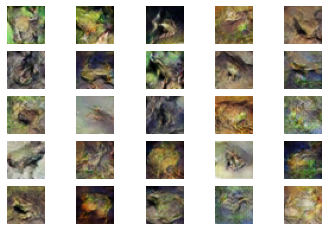

>196, 1/39, d1=0.448, d2=0.570 g=1.258
>196, 2/39, d1=0.611, d2=0.439 g=1.175
>196, 3/39, d1=0.548, d2=0.538 g=1.155
>196, 4/39, d1=0.573, d2=0.551 g=1.156
>196, 5/39, d1=0.539, d2=0.613 g=1.228
>196, 6/39, d1=0.614, d2=0.558 g=1.329
>196, 7/39, d1=0.643, d2=0.538 g=1.266
>196, 8/39, d1=0.654, d2=0.441 g=1.218
>196, 9/39, d1=0.528, d2=0.685 g=1.232
>196, 10/39, d1=0.527, d2=0.455 g=1.225
>196, 11/39, d1=0.586, d2=0.542 g=1.190
>196, 12/39, d1=0.662, d2=0.662 g=1.175
>196, 13/39, d1=0.637, d2=0.577 g=1.153
>196, 14/39, d1=0.475, d2=0.529 g=1.190
>196, 15/39, d1=0.470, d2=0.528 g=1.232
>196, 16/39, d1=0.545, d2=0.637 g=1.310
>196, 17/39, d1=0.620, d2=0.425 g=1.215
>196, 18/39, d1=0.600, d2=0.536 g=1.167
>196, 19/39, d1=0.554, d2=0.719 g=1.347
>196, 20/39, d1=0.649, d2=0.457 g=1.154
>196, 21/39, d1=0.543, d2=0.793 g=1.168
>196, 22/39, d1=0.647, d2=0.480 g=1.203
>196, 23/39, d1=0.689, d2=0.470 g=1.078
>196, 24/39, d1=0.580, d2=0.658 g=1.121
>196, 25/39, d1=0.480, d2=0.542 g=1.258
>196, 26/

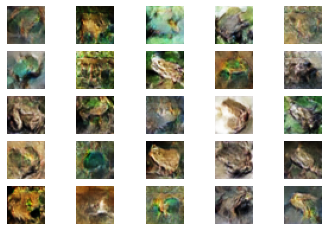

>201, 1/39, d1=0.481, d2=0.539 g=1.344
>201, 2/39, d1=0.608, d2=0.523 g=1.247
>201, 3/39, d1=0.680, d2=0.505 g=1.228
>201, 4/39, d1=0.505, d2=0.617 g=1.229
>201, 5/39, d1=0.501, d2=0.503 g=1.241
>201, 6/39, d1=0.583, d2=0.499 g=1.340
>201, 7/39, d1=0.463, d2=0.561 g=1.424
>201, 8/39, d1=0.502, d2=0.537 g=1.455
>201, 9/39, d1=0.544, d2=0.431 g=1.358
>201, 10/39, d1=0.521, d2=0.441 g=1.444
>201, 11/39, d1=0.475, d2=0.578 g=1.437
>201, 12/39, d1=0.564, d2=0.424 g=1.459
>201, 13/39, d1=0.620, d2=0.517 g=1.348
>201, 14/39, d1=0.607, d2=0.599 g=1.263
>201, 15/39, d1=0.675, d2=0.531 g=1.312
>201, 16/39, d1=0.531, d2=0.570 g=1.301
>201, 17/39, d1=0.649, d2=0.548 g=1.143
>201, 18/39, d1=0.493, d2=0.608 g=1.136
>201, 19/39, d1=0.458, d2=0.632 g=1.240
>201, 20/39, d1=0.489, d2=0.551 g=1.256
>201, 21/39, d1=0.598, d2=0.469 g=1.296
>201, 22/39, d1=0.566, d2=0.640 g=1.297
>201, 23/39, d1=0.539, d2=0.462 g=1.252
>201, 24/39, d1=0.517, d2=0.537 g=1.325
>201, 25/39, d1=0.547, d2=0.459 g=1.341
>201, 26/

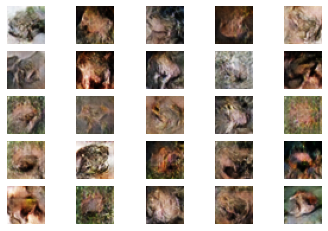

>206, 1/39, d1=0.426, d2=0.547 g=1.473
>206, 2/39, d1=0.628, d2=0.437 g=1.347
>206, 3/39, d1=0.583, d2=0.495 g=1.380
>206, 4/39, d1=0.636, d2=0.448 g=1.277
>206, 5/39, d1=0.513, d2=0.475 g=1.274
>206, 6/39, d1=0.405, d2=0.451 g=1.264
>206, 7/39, d1=0.484, d2=0.521 g=1.244
>206, 8/39, d1=0.398, d2=0.630 g=1.400
>206, 9/39, d1=0.473, d2=0.489 g=1.360
>206, 10/39, d1=0.568, d2=0.482 g=1.297
>206, 11/39, d1=0.578, d2=0.585 g=1.302
>206, 12/39, d1=0.490, d2=0.491 g=1.420
>206, 13/39, d1=0.597, d2=0.503 g=1.332
>206, 14/39, d1=0.531, d2=0.645 g=1.267
>206, 15/39, d1=0.546, d2=0.477 g=1.394
>206, 16/39, d1=0.564, d2=0.566 g=1.501
>206, 17/39, d1=0.485, d2=0.435 g=1.511
>206, 18/39, d1=0.549, d2=0.534 g=1.406
>206, 19/39, d1=0.533, d2=0.646 g=1.422
>206, 20/39, d1=0.565, d2=0.438 g=1.334
>206, 21/39, d1=0.484, d2=0.491 g=1.302
>206, 22/39, d1=0.588, d2=0.485 g=1.242
>206, 23/39, d1=0.454, d2=0.502 g=1.209
>206, 24/39, d1=0.523, d2=0.584 g=1.215
>206, 25/39, d1=0.448, d2=0.519 g=1.300
>206, 26/

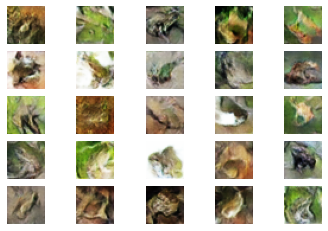

>211, 1/39, d1=0.478, d2=0.480 g=1.499
>211, 2/39, d1=0.551, d2=0.391 g=1.363
>211, 3/39, d1=0.554, d2=0.484 g=1.217
>211, 4/39, d1=0.507, d2=0.520 g=1.213
>211, 5/39, d1=0.580, d2=0.636 g=1.347
>211, 6/39, d1=0.396, d2=0.603 g=1.318
>211, 7/39, d1=0.560, d2=0.466 g=1.269
>211, 8/39, d1=0.521, d2=0.528 g=1.319
>211, 9/39, d1=0.427, d2=0.671 g=1.283
>211, 10/39, d1=0.556, d2=0.480 g=1.438
>211, 11/39, d1=0.587, d2=0.409 g=1.409
>211, 12/39, d1=0.512, d2=0.490 g=1.362
>211, 13/39, d1=0.420, d2=0.594 g=1.384
>211, 14/39, d1=0.524, d2=0.444 g=1.349
>211, 15/39, d1=0.597, d2=0.727 g=1.385
>211, 16/39, d1=0.689, d2=0.530 g=1.451
>211, 17/39, d1=0.639, d2=0.462 g=1.343
>211, 18/39, d1=0.554, d2=0.540 g=1.303
>211, 19/39, d1=0.524, d2=0.456 g=1.337
>211, 20/39, d1=0.623, d2=0.542 g=1.396
>211, 21/39, d1=0.465, d2=0.427 g=1.295
>211, 22/39, d1=0.563, d2=0.595 g=1.353
>211, 23/39, d1=0.571, d2=0.485 g=1.381
>211, 24/39, d1=0.584, d2=0.443 g=1.188
>211, 25/39, d1=0.536, d2=0.541 g=1.210
>211, 26/

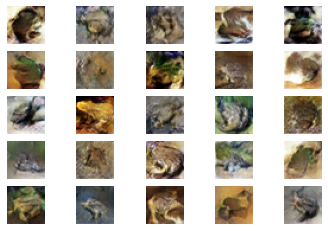

>216, 1/39, d1=0.394, d2=0.373 g=1.455
>216, 2/39, d1=0.689, d2=0.404 g=1.340
>216, 3/39, d1=0.591, d2=0.584 g=1.271
>216, 4/39, d1=0.571, d2=0.545 g=1.305
>216, 5/39, d1=0.470, d2=0.618 g=1.401
>216, 6/39, d1=0.563, d2=0.529 g=1.340
>216, 7/39, d1=0.531, d2=0.511 g=1.263
>216, 8/39, d1=0.477, d2=0.479 g=1.306
>216, 9/39, d1=0.391, d2=0.548 g=1.410
>216, 10/39, d1=0.460, d2=0.471 g=1.524
>216, 11/39, d1=0.534, d2=0.403 g=1.522
>216, 12/39, d1=0.451, d2=0.537 g=1.453
>216, 13/39, d1=0.456, d2=0.520 g=1.523
>216, 14/39, d1=0.500, d2=0.484 g=1.550
>216, 15/39, d1=0.571, d2=0.421 g=1.412
>216, 16/39, d1=0.591, d2=0.528 g=1.347
>216, 17/39, d1=0.523, d2=0.479 g=1.486
>216, 18/39, d1=0.574, d2=0.722 g=1.486
>216, 19/39, d1=0.608, d2=0.402 g=1.535
>216, 20/39, d1=0.587, d2=0.504 g=1.389
>216, 21/39, d1=0.555, d2=0.574 g=1.417
>216, 22/39, d1=0.549, d2=0.452 g=1.409
>216, 23/39, d1=0.491, d2=0.465 g=1.421
>216, 24/39, d1=0.547, d2=0.602 g=1.534
>216, 25/39, d1=0.458, d2=0.428 g=1.560
>216, 26/

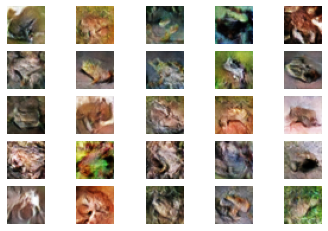

>221, 1/39, d1=0.468, d2=0.694 g=1.583
>221, 2/39, d1=0.625, d2=0.456 g=1.410
>221, 3/39, d1=0.552, d2=0.553 g=1.546
>221, 4/39, d1=0.563, d2=0.346 g=1.497
>221, 5/39, d1=0.569, d2=0.445 g=1.477
>221, 6/39, d1=0.545, d2=0.626 g=1.423
>221, 7/39, d1=0.657, d2=0.476 g=1.444
>221, 8/39, d1=0.546, d2=0.496 g=1.491
>221, 9/39, d1=0.493, d2=0.500 g=1.429
>221, 10/39, d1=0.597, d2=0.496 g=1.369
>221, 11/39, d1=0.456, d2=0.497 g=1.459
>221, 12/39, d1=0.501, d2=0.598 g=1.441
>221, 13/39, d1=0.516, d2=0.449 g=1.424
>221, 14/39, d1=0.415, d2=0.422 g=1.414
>221, 15/39, d1=0.546, d2=0.643 g=1.462
>221, 16/39, d1=0.456, d2=0.467 g=1.355
>221, 17/39, d1=0.654, d2=0.499 g=1.271
>221, 18/39, d1=0.535, d2=0.583 g=1.330
>221, 19/39, d1=0.662, d2=0.564 g=1.457
>221, 20/39, d1=0.581, d2=0.458 g=1.456
>221, 21/39, d1=0.454, d2=0.428 g=1.410
>221, 22/39, d1=0.413, d2=0.489 g=1.438
>221, 23/39, d1=0.547, d2=0.532 g=1.466
>221, 24/39, d1=0.487, d2=0.492 g=1.617
>221, 25/39, d1=0.451, d2=0.450 g=1.547
>221, 26/

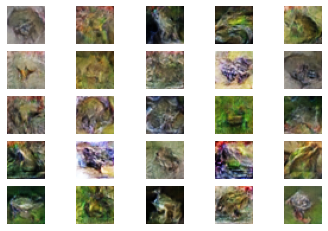

>226, 1/39, d1=0.382, d2=0.441 g=1.526
>226, 2/39, d1=0.485, d2=0.397 g=1.506
>226, 3/39, d1=0.559, d2=0.544 g=1.299
>226, 4/39, d1=0.432, d2=0.721 g=1.557
>226, 5/39, d1=0.655, d2=0.464 g=1.780
>226, 6/39, d1=0.508, d2=0.519 g=1.764
>226, 7/39, d1=0.585, d2=0.506 g=1.602
>226, 8/39, d1=0.675, d2=0.616 g=1.525
>226, 9/39, d1=0.674, d2=0.482 g=1.470
>226, 10/39, d1=0.606, d2=0.492 g=1.365
>226, 11/39, d1=0.463, d2=0.467 g=1.289
>226, 12/39, d1=0.549, d2=0.438 g=1.374
>226, 13/39, d1=0.477, d2=0.471 g=1.493
>226, 14/39, d1=0.466, d2=0.432 g=1.479
>226, 15/39, d1=0.533, d2=0.466 g=1.401
>226, 16/39, d1=0.590, d2=0.520 g=1.471
>226, 17/39, d1=0.526, d2=0.453 g=1.443
>226, 18/39, d1=0.393, d2=0.583 g=1.617
>226, 19/39, d1=0.644, d2=0.407 g=1.631
>226, 20/39, d1=0.635, d2=0.584 g=1.628
>226, 21/39, d1=0.513, d2=0.424 g=1.567
>226, 22/39, d1=0.573, d2=0.387 g=1.490
>226, 23/39, d1=0.431, d2=0.603 g=1.518
>226, 24/39, d1=0.371, d2=0.425 g=1.440
>226, 25/39, d1=0.535, d2=0.551 g=1.660
>226, 26/

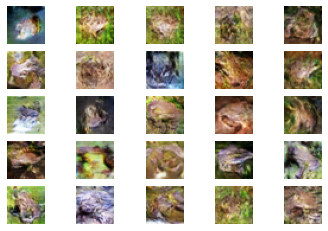

>231, 1/39, d1=0.378, d2=0.402 g=1.581
>231, 2/39, d1=0.380, d2=0.443 g=1.507
>231, 3/39, d1=0.422, d2=0.583 g=1.579
>231, 4/39, d1=0.557, d2=0.470 g=1.785
>231, 5/39, d1=0.525, d2=0.385 g=1.496
>231, 6/39, d1=0.431, d2=0.521 g=1.640
>231, 7/39, d1=0.573, d2=0.541 g=1.579
>231, 8/39, d1=0.568, d2=0.352 g=1.531
>231, 9/39, d1=0.418, d2=0.535 g=1.435
>231, 10/39, d1=0.577, d2=0.589 g=1.537
>231, 11/39, d1=0.419, d2=0.443 g=1.709
>231, 12/39, d1=0.452, d2=0.318 g=1.554
>231, 13/39, d1=0.427, d2=0.543 g=1.513
>231, 14/39, d1=0.462, d2=0.514 g=1.472
>231, 15/39, d1=0.460, d2=0.495 g=1.490
>231, 16/39, d1=0.339, d2=0.455 g=1.681
>231, 17/39, d1=0.579, d2=0.502 g=1.496
>231, 18/39, d1=0.429, d2=0.482 g=1.542
>231, 19/39, d1=0.417, d2=0.595 g=1.513
>231, 20/39, d1=0.483, d2=0.362 g=1.533
>231, 21/39, d1=0.530, d2=0.455 g=1.480
>231, 22/39, d1=0.482, d2=0.599 g=1.744
>231, 23/39, d1=0.498, d2=0.430 g=1.468
>231, 24/39, d1=0.509, d2=0.491 g=1.551
>231, 25/39, d1=0.495, d2=0.496 g=1.562
>231, 26/

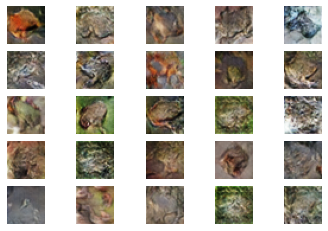

>236, 1/39, d1=0.397, d2=0.353 g=1.467
>236, 2/39, d1=0.589, d2=0.674 g=1.732
>236, 3/39, d1=0.568, d2=0.475 g=1.621
>236, 4/39, d1=0.444, d2=0.496 g=1.563
>236, 5/39, d1=0.480, d2=0.427 g=1.573
>236, 6/39, d1=0.486, d2=0.495 g=1.608
>236, 7/39, d1=0.493, d2=0.707 g=1.777
>236, 8/39, d1=0.474, d2=0.350 g=1.651
>236, 9/39, d1=0.461, d2=0.532 g=1.587
>236, 10/39, d1=0.538, d2=0.428 g=1.562
>236, 11/39, d1=0.597, d2=0.529 g=1.582
>236, 12/39, d1=0.534, d2=0.502 g=1.452
>236, 13/39, d1=0.444, d2=0.465 g=1.393
>236, 14/39, d1=0.448, d2=0.521 g=1.407
>236, 15/39, d1=0.407, d2=0.520 g=1.471
>236, 16/39, d1=0.472, d2=0.568 g=1.709
>236, 17/39, d1=0.548, d2=0.399 g=1.592
>236, 18/39, d1=0.722, d2=0.437 g=1.445
>236, 19/39, d1=0.474, d2=0.549 g=1.621
>236, 20/39, d1=0.549, d2=0.483 g=1.484
>236, 21/39, d1=0.568, d2=0.465 g=1.465
>236, 22/39, d1=0.546, d2=0.426 g=1.527
>236, 23/39, d1=0.423, d2=0.560 g=1.474
>236, 24/39, d1=0.432, d2=0.389 g=1.544
>236, 25/39, d1=0.414, d2=0.475 g=1.498
>236, 26/

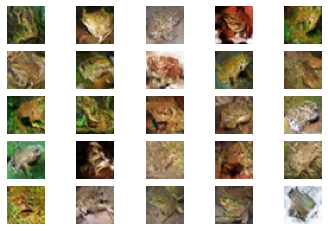

>241, 1/39, d1=0.397, d2=0.452 g=1.559
>241, 2/39, d1=0.529, d2=0.513 g=1.455
>241, 3/39, d1=0.434, d2=0.500 g=1.493
>241, 4/39, d1=0.484, d2=0.483 g=1.443
>241, 5/39, d1=0.517, d2=0.587 g=1.687
>241, 6/39, d1=0.519, d2=0.475 g=1.756
>241, 7/39, d1=0.489, d2=0.405 g=1.663
>241, 8/39, d1=0.564, d2=0.402 g=1.524
>241, 9/39, d1=0.402, d2=0.560 g=1.650
>241, 10/39, d1=0.565, d2=0.421 g=1.528
>241, 11/39, d1=0.424, d2=0.450 g=1.625
>241, 12/39, d1=0.517, d2=0.450 g=1.621
>241, 13/39, d1=0.543, d2=0.534 g=1.616
>241, 14/39, d1=0.514, d2=0.458 g=1.617
>241, 15/39, d1=0.527, d2=0.501 g=1.685
>241, 16/39, d1=0.521, d2=0.494 g=1.579
>241, 17/39, d1=0.440, d2=0.429 g=1.507
>241, 18/39, d1=0.461, d2=0.512 g=1.530
>241, 19/39, d1=0.410, d2=0.453 g=1.813
>241, 20/39, d1=0.592, d2=0.441 g=1.948
>241, 21/39, d1=0.538, d2=0.527 g=1.752
>241, 22/39, d1=0.457, d2=0.423 g=1.511
>241, 23/39, d1=0.671, d2=0.502 g=1.751
>241, 24/39, d1=0.440, d2=0.402 g=1.761
>241, 25/39, d1=0.490, d2=0.401 g=1.607
>241, 26/

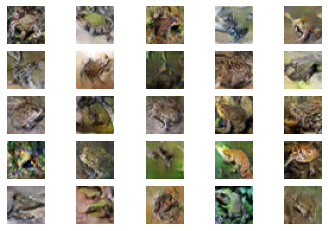

>246, 1/39, d1=0.364, d2=0.572 g=1.645
>246, 2/39, d1=0.539, d2=0.465 g=1.630
>246, 3/39, d1=0.491, d2=0.392 g=1.566
>246, 4/39, d1=0.514, d2=0.465 g=1.695
>246, 5/39, d1=0.504, d2=0.508 g=1.755
>246, 6/39, d1=0.414, d2=0.504 g=1.835
>246, 7/39, d1=0.553, d2=0.382 g=1.804
>246, 8/39, d1=0.481, d2=0.380 g=1.813
>246, 9/39, d1=0.542, d2=0.463 g=1.571
>246, 10/39, d1=0.428, d2=0.440 g=1.644
>246, 11/39, d1=0.515, d2=0.426 g=1.573
>246, 12/39, d1=0.369, d2=0.626 g=1.778
>246, 13/39, d1=0.576, d2=0.532 g=1.692
>246, 14/39, d1=0.567, d2=0.501 g=1.671
>246, 15/39, d1=0.665, d2=0.404 g=1.731
>246, 16/39, d1=0.463, d2=0.514 g=1.490
>246, 17/39, d1=0.502, d2=0.546 g=1.496
>246, 18/39, d1=0.507, d2=0.501 g=1.575
>246, 19/39, d1=0.524, d2=0.422 g=1.472
>246, 20/39, d1=0.424, d2=0.424 g=1.366
>246, 21/39, d1=0.421, d2=0.596 g=1.454
>246, 22/39, d1=0.337, d2=0.555 g=2.030
>246, 23/39, d1=0.417, d2=0.455 g=1.600
>246, 24/39, d1=0.492, d2=0.406 g=1.689
>246, 25/39, d1=0.533, d2=0.383 g=1.681
>246, 26/

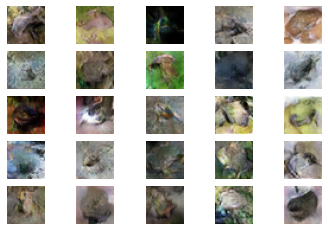

>251, 1/39, d1=0.380, d2=0.399 g=1.566
>251, 2/39, d1=0.429, d2=0.443 g=1.588
>251, 3/39, d1=0.414, d2=0.455 g=1.615
>251, 4/39, d1=0.395, d2=0.452 g=1.565
>251, 5/39, d1=0.416, d2=0.387 g=1.503
>251, 6/39, d1=0.339, d2=0.528 g=1.642
>251, 7/39, d1=0.336, d2=0.390 g=1.821
>251, 8/39, d1=0.329, d2=0.382 g=1.882
>251, 9/39, d1=0.585, d2=0.443 g=1.776
>251, 10/39, d1=0.417, d2=0.346 g=1.767
>251, 11/39, d1=0.487, d2=0.773 g=1.896
>251, 12/39, d1=0.602, d2=0.373 g=1.870
>251, 13/39, d1=0.640, d2=0.471 g=1.741
>251, 14/39, d1=0.545, d2=0.551 g=1.814
>251, 15/39, d1=0.637, d2=0.485 g=1.665
>251, 16/39, d1=0.467, d2=0.514 g=1.667
>251, 17/39, d1=0.589, d2=0.404 g=1.661
>251, 18/39, d1=0.412, d2=0.488 g=1.738
>251, 19/39, d1=0.434, d2=0.532 g=1.677
>251, 20/39, d1=0.508, d2=0.436 g=1.754
>251, 21/39, d1=0.454, d2=0.326 g=1.727
>251, 22/39, d1=0.496, d2=0.352 g=1.592
>251, 23/39, d1=0.333, d2=0.490 g=1.697
>251, 24/39, d1=0.470, d2=0.422 g=1.763
>251, 25/39, d1=0.418, d2=0.357 g=1.855
>251, 26/

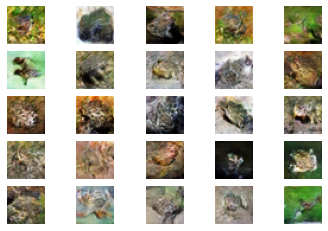

>256, 1/39, d1=0.463, d2=0.612 g=1.537
>256, 2/39, d1=0.596, d2=0.554 g=1.405
>256, 3/39, d1=0.516, d2=0.483 g=1.497
>256, 4/39, d1=0.398, d2=0.477 g=1.697
>256, 5/39, d1=0.578, d2=0.492 g=1.703
>256, 6/39, d1=0.541, d2=0.525 g=1.455
>256, 7/39, d1=0.541, d2=0.459 g=1.502
>256, 8/39, d1=0.434, d2=0.519 g=1.366
>256, 9/39, d1=0.462, d2=0.426 g=1.420
>256, 10/39, d1=0.597, d2=0.452 g=1.483
>256, 11/39, d1=0.531, d2=0.533 g=1.406
>256, 12/39, d1=0.441, d2=0.548 g=1.520
>256, 13/39, d1=0.513, d2=0.525 g=1.536
>256, 14/39, d1=0.433, d2=0.541 g=1.629
>256, 15/39, d1=0.597, d2=0.341 g=1.566
>256, 16/39, d1=0.584, d2=0.527 g=1.433
>256, 17/39, d1=0.495, d2=0.516 g=1.467
>256, 18/39, d1=0.503, d2=0.438 g=1.474
>256, 19/39, d1=0.546, d2=0.559 g=1.428
>256, 20/39, d1=0.462, d2=0.395 g=1.374
>256, 21/39, d1=0.586, d2=0.512 g=1.367
>256, 22/39, d1=0.523, d2=0.543 g=1.309
>256, 23/39, d1=0.438, d2=0.481 g=1.479
>256, 24/39, d1=0.552, d2=0.538 g=1.601
>256, 25/39, d1=0.507, d2=0.474 g=1.421
>256, 26/

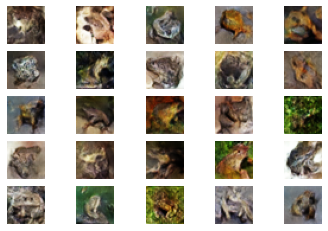

>261, 1/39, d1=0.403, d2=0.360 g=1.705
>261, 2/39, d1=0.338, d2=0.457 g=1.716
>261, 3/39, d1=0.649, d2=0.489 g=1.690
>261, 4/39, d1=0.369, d2=0.417 g=1.632
>261, 5/39, d1=0.526, d2=0.452 g=1.549
>261, 6/39, d1=0.443, d2=0.440 g=1.766
>261, 7/39, d1=0.398, d2=0.359 g=1.552
>261, 8/39, d1=0.462, d2=0.396 g=1.673
>261, 9/39, d1=0.339, d2=0.570 g=1.591
>261, 10/39, d1=0.514, d2=0.504 g=1.855
>261, 11/39, d1=0.506, d2=0.467 g=1.782
>261, 12/39, d1=0.468, d2=0.513 g=2.003
>261, 13/39, d1=0.638, d2=0.367 g=1.629
>261, 14/39, d1=0.554, d2=0.577 g=1.557
>261, 15/39, d1=0.362, d2=0.468 g=1.552
>261, 16/39, d1=0.458, d2=0.459 g=1.502
>261, 17/39, d1=0.334, d2=0.475 g=1.634
>261, 18/39, d1=0.437, d2=0.469 g=1.783
>261, 19/39, d1=0.493, d2=0.411 g=1.692
>261, 20/39, d1=0.354, d2=0.382 g=1.613
>261, 21/39, d1=0.352, d2=0.489 g=1.636
>261, 22/39, d1=0.429, d2=0.468 g=1.641
>261, 23/39, d1=0.630, d2=0.528 g=1.680
>261, 24/39, d1=0.520, d2=0.391 g=1.904
>261, 25/39, d1=0.515, d2=0.528 g=1.729
>261, 26/

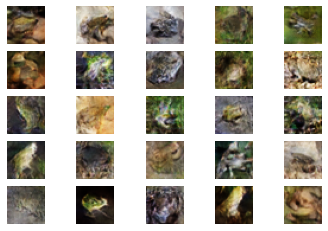

>266, 1/39, d1=0.368, d2=0.416 g=1.865
>266, 2/39, d1=0.424, d2=0.451 g=1.986
>266, 3/39, d1=0.472, d2=0.355 g=1.849
>266, 4/39, d1=0.523, d2=0.435 g=1.908
>266, 5/39, d1=0.297, d2=0.354 g=1.688
>266, 6/39, d1=0.431, d2=0.435 g=1.777
>266, 7/39, d1=0.449, d2=0.420 g=1.678
>266, 8/39, d1=0.424, d2=0.379 g=1.655
>266, 9/39, d1=0.352, d2=0.508 g=1.934
>266, 10/39, d1=0.548, d2=0.506 g=1.887
>266, 11/39, d1=0.431, d2=0.354 g=2.030
>266, 12/39, d1=0.412, d2=0.405 g=1.882
>266, 13/39, d1=0.502, d2=0.440 g=1.910
>266, 14/39, d1=0.460, d2=0.400 g=1.925
>266, 15/39, d1=0.450, d2=0.518 g=1.880
>266, 16/39, d1=0.412, d2=0.427 g=1.840
>266, 17/39, d1=0.454, d2=0.490 g=1.849
>266, 18/39, d1=0.327, d2=0.277 g=1.760
>266, 19/39, d1=0.497, d2=0.490 g=1.905
>266, 20/39, d1=0.364, d2=0.403 g=2.083
>266, 21/39, d1=0.479, d2=0.306 g=1.732
>266, 22/39, d1=0.421, d2=0.466 g=1.810
>266, 23/39, d1=0.487, d2=0.537 g=1.840
>266, 24/39, d1=0.515, d2=0.465 g=1.698
>266, 25/39, d1=0.545, d2=0.414 g=1.772
>266, 26/

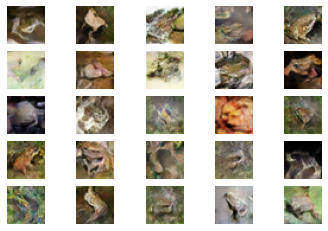

>271, 1/39, d1=0.357, d2=0.430 g=1.922
>271, 2/39, d1=0.536, d2=0.451 g=1.841
>271, 3/39, d1=0.499, d2=0.291 g=1.766
>271, 4/39, d1=0.346, d2=0.577 g=2.036
>271, 5/39, d1=0.490, d2=0.373 g=1.919
>271, 6/39, d1=0.584, d2=0.440 g=1.814
>271, 7/39, d1=0.397, d2=0.437 g=1.953
>271, 8/39, d1=0.429, d2=0.587 g=1.997
>271, 9/39, d1=0.456, d2=0.369 g=2.084
>271, 10/39, d1=0.431, d2=0.368 g=2.039
>271, 11/39, d1=0.490, d2=0.372 g=1.830
>271, 12/39, d1=0.364, d2=0.459 g=2.035
>271, 13/39, d1=0.423, d2=0.404 g=2.223
>271, 14/39, d1=0.309, d2=0.280 g=2.038
>271, 15/39, d1=0.508, d2=0.409 g=2.090
>271, 16/39, d1=0.377, d2=0.322 g=2.020
>271, 17/39, d1=0.550, d2=0.420 g=1.896
>271, 18/39, d1=0.476, d2=0.481 g=1.901
>271, 19/39, d1=0.391, d2=0.442 g=1.932
>271, 20/39, d1=0.280, d2=0.417 g=1.844
>271, 21/39, d1=0.369, d2=0.454 g=1.859
>271, 22/39, d1=0.425, d2=0.494 g=1.865
>271, 23/39, d1=0.425, d2=0.421 g=1.969
>271, 24/39, d1=0.626, d2=0.441 g=1.861
>271, 25/39, d1=0.547, d2=0.389 g=1.716
>271, 26/

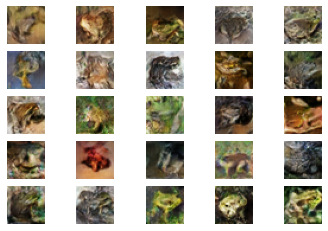

>276, 1/39, d1=0.358, d2=0.531 g=1.834
>276, 2/39, d1=0.479, d2=0.373 g=1.829
>276, 3/39, d1=0.368, d2=0.375 g=1.820
>276, 4/39, d1=0.620, d2=0.395 g=1.890
>276, 5/39, d1=0.394, d2=0.562 g=1.900
>276, 6/39, d1=0.446, d2=0.478 g=1.804
>276, 7/39, d1=0.373, d2=0.342 g=1.970
>276, 8/39, d1=0.472, d2=0.480 g=1.884
>276, 9/39, d1=0.497, d2=0.423 g=1.805
>276, 10/39, d1=0.446, d2=0.658 g=2.102
>276, 11/39, d1=0.378, d2=0.311 g=1.957
>276, 12/39, d1=0.587, d2=0.294 g=1.723
>276, 13/39, d1=0.432, d2=0.441 g=1.638
>276, 14/39, d1=0.311, d2=0.397 g=1.794
>276, 15/39, d1=0.393, d2=0.478 g=1.877
>276, 16/39, d1=0.338, d2=0.396 g=1.825
>276, 17/39, d1=0.551, d2=0.449 g=1.782
>276, 18/39, d1=0.389, d2=0.469 g=1.803
>276, 19/39, d1=0.389, d2=0.450 g=1.837
>276, 20/39, d1=0.395, d2=0.339 g=1.886
>276, 21/39, d1=0.328, d2=0.606 g=2.100
>276, 22/39, d1=0.422, d2=0.389 g=2.031
>276, 23/39, d1=0.447, d2=0.483 g=1.814
>276, 24/39, d1=0.516, d2=0.545 g=2.005
>276, 25/39, d1=0.278, d2=0.267 g=2.079
>276, 26/

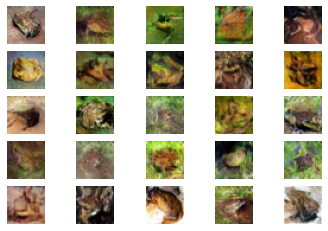

>281, 1/39, d1=0.323, d2=0.377 g=1.917
>281, 2/39, d1=0.355, d2=0.414 g=1.690
>281, 3/39, d1=0.376, d2=0.539 g=1.851
>281, 4/39, d1=0.432, d2=0.394 g=1.934
>281, 5/39, d1=0.376, d2=0.432 g=2.240
>281, 6/39, d1=0.449, d2=0.341 g=2.020
>281, 7/39, d1=0.395, d2=0.344 g=2.039
>281, 8/39, d1=0.453, d2=0.393 g=1.973
>281, 9/39, d1=0.361, d2=0.296 g=2.157
>281, 10/39, d1=0.411, d2=0.355 g=1.948
>281, 11/39, d1=0.277, d2=0.336 g=2.140
>281, 12/39, d1=0.256, d2=0.311 g=2.268
>281, 13/39, d1=0.470, d2=0.344 g=1.880
>281, 14/39, d1=0.390, d2=0.414 g=2.147
>281, 15/39, d1=0.362, d2=0.530 g=2.032
>281, 16/39, d1=0.394, d2=0.382 g=2.169
>281, 17/39, d1=0.496, d2=0.384 g=1.979
>281, 18/39, d1=0.343, d2=0.478 g=2.131
>281, 19/39, d1=0.406, d2=0.309 g=2.042
>281, 20/39, d1=0.478, d2=0.319 g=1.920
>281, 21/39, d1=0.268, d2=0.489 g=2.094
>281, 22/39, d1=0.510, d2=0.545 g=2.028
>281, 23/39, d1=0.362, d2=0.357 g=2.070
>281, 24/39, d1=0.463, d2=0.366 g=2.214
>281, 25/39, d1=0.425, d2=0.380 g=2.137
>281, 26/

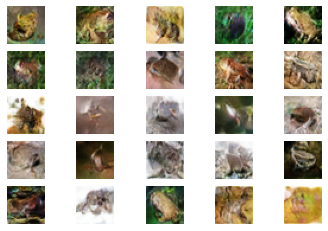

>286, 1/39, d1=0.314, d2=0.399 g=2.140
>286, 2/39, d1=0.332, d2=0.268 g=2.280
>286, 3/39, d1=0.486, d2=0.405 g=2.038
>286, 4/39, d1=0.433, d2=0.454 g=2.152
>286, 5/39, d1=0.379, d2=0.496 g=2.077
>286, 6/39, d1=0.419, d2=0.337 g=2.133
>286, 7/39, d1=0.349, d2=0.399 g=2.208
>286, 8/39, d1=0.496, d2=0.491 g=2.007
>286, 9/39, d1=0.400, d2=0.412 g=2.072
>286, 10/39, d1=0.387, d2=0.392 g=2.203
>286, 11/39, d1=0.286, d2=0.382 g=2.302
>286, 12/39, d1=0.328, d2=0.274 g=2.119
>286, 13/39, d1=0.460, d2=0.642 g=2.305
>286, 14/39, d1=0.387, d2=0.333 g=2.238
>286, 15/39, d1=0.468, d2=0.412 g=2.155
>286, 16/39, d1=0.448, d2=0.451 g=2.264
>286, 17/39, d1=0.520, d2=0.433 g=2.166
>286, 18/39, d1=0.485, d2=0.376 g=2.087
>286, 19/39, d1=0.384, d2=0.268 g=2.073
>286, 20/39, d1=0.523, d2=0.407 g=2.039
>286, 21/39, d1=0.294, d2=0.423 g=1.990
>286, 22/39, d1=0.345, d2=0.307 g=2.121
>286, 23/39, d1=0.414, d2=0.421 g=2.168
>286, 24/39, d1=0.425, d2=0.366 g=2.114
>286, 25/39, d1=0.354, d2=0.401 g=2.203
>286, 26/

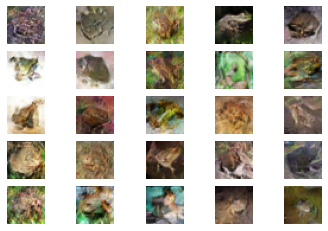

>291, 1/39, d1=0.331, d2=0.309 g=1.892
>291, 2/39, d1=0.161, d2=0.365 g=2.179
>291, 3/39, d1=0.330, d2=0.506 g=2.236
>291, 4/39, d1=0.548, d2=0.239 g=2.057
>291, 5/39, d1=0.401, d2=0.362 g=2.127
>291, 6/39, d1=0.213, d2=0.395 g=2.211
>291, 7/39, d1=0.371, d2=0.249 g=2.186
>291, 8/39, d1=0.269, d2=0.396 g=2.141
>291, 9/39, d1=0.259, d2=0.327 g=1.951
>291, 10/39, d1=0.365, d2=0.439 g=2.103
>291, 11/39, d1=0.462, d2=0.428 g=1.996
>291, 12/39, d1=0.395, d2=0.393 g=2.137
>291, 13/39, d1=0.386, d2=0.348 g=2.208
>291, 14/39, d1=0.417, d2=0.505 g=2.449
>291, 15/39, d1=0.462, d2=0.231 g=2.229
>291, 16/39, d1=0.394, d2=0.475 g=2.301
>291, 17/39, d1=0.412, d2=0.463 g=2.115
>291, 18/39, d1=0.402, d2=0.369 g=2.212
>291, 19/39, d1=0.341, d2=0.327 g=2.100
>291, 20/39, d1=0.503, d2=0.429 g=2.112
>291, 21/39, d1=0.287, d2=0.339 g=2.281
>291, 22/39, d1=0.238, d2=0.248 g=2.181
>291, 23/39, d1=0.375, d2=0.516 g=2.322
>291, 24/39, d1=0.447, d2=0.440 g=2.150
>291, 25/39, d1=0.368, d2=0.332 g=1.964
>291, 26/

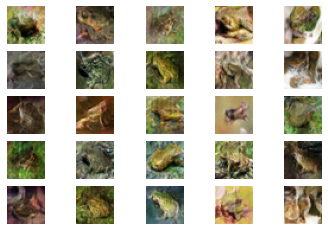

>296, 1/39, d1=0.295, d2=0.348 g=2.163
>296, 2/39, d1=0.381, d2=0.311 g=2.119
>296, 3/39, d1=0.412, d2=0.452 g=2.220
>296, 4/39, d1=0.299, d2=0.368 g=2.395
>296, 5/39, d1=0.515, d2=0.318 g=2.106
>296, 6/39, d1=0.399, d2=0.455 g=1.839
>296, 7/39, d1=0.377, d2=0.421 g=2.113
>296, 8/39, d1=0.322, d2=0.422 g=2.270
>296, 9/39, d1=0.388, d2=0.298 g=2.363
>296, 10/39, d1=0.381, d2=0.339 g=2.036
>296, 11/39, d1=0.294, d2=0.537 g=2.483
>296, 12/39, d1=0.438, d2=0.273 g=2.281
>296, 13/39, d1=0.385, d2=0.346 g=2.139
>296, 14/39, d1=0.371, d2=0.410 g=2.103
>296, 15/39, d1=0.431, d2=0.458 g=2.476
>296, 16/39, d1=0.355, d2=0.363 g=2.495
>296, 17/39, d1=0.416, d2=0.308 g=2.528
>296, 18/39, d1=0.521, d2=0.386 g=2.277
>296, 19/39, d1=0.421, d2=0.552 g=2.125
>296, 20/39, d1=0.367, d2=0.507 g=2.281
>296, 21/39, d1=0.387, d2=0.387 g=2.637
>296, 22/39, d1=0.384, d2=0.256 g=2.580
>296, 23/39, d1=0.451, d2=0.342 g=2.433
>296, 24/39, d1=0.324, d2=0.357 g=2.023
>296, 25/39, d1=0.313, d2=0.309 g=2.141
>296, 26/

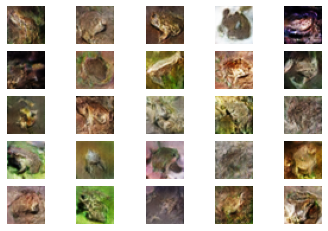

In [ ]:
# size of latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)